# **Applied Data Science**

---

**Homework 3**

**Erfan Karami**

**Date:** Winter 2025

**Tehran Institute for Advanced Studies**

---

In [189]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset



# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

#  Multilayer Perceptron (MLP)

For this part of homework we use Dataset we used in previous homeworks (`Iran Job Ads dataset`) and same classification and regression problem:\\
- Predict avg salary for regression task
- predict class of sallary( `low` and `high(top 25%)`) for classification task

In [2]:
# loading dataset


jobs = pd.read_csv('../dataset/jobs_cleaned.csv')
jobs

,company_size,مدرک لازم نیست,کاردانی,کاردانی کارشناسی,کاردانی کارشناسی کارشناسی ارشد,کارشناسی,کارشناسی کارشناسی ارشد,ترجیحاً آقا,ترجیحاً خانم,تفاوتی ندارد,...,software_هلو,software_همکاران سیستم,software_ورا نگر,software_ویژن,software_پیام گستر,software_پیوست,وضعیت سربازی ـ الزامی,وضعیت سربازی ـ مهم نیست,min_age_required,max_age_required
0,30.0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,23.0,33.0
1,125.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,23.0,45.0
2,5000.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,24.0,35.0
3,30.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,25.0,43.0
4,750.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,20.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34096,125.0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,22.0,50.0
34097,350.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,25.0,40.0
34098,750.0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,24.0,37.0
34099,30.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,35.0,45.0


In [3]:
cols_with_missing = jobs.columns[jobs.isnull().any()]
print(cols_with_missing)

Index(['min_salary', 'max_salary', 'is_flexible'], dtype='object')


In [4]:
jobs = jobs.dropna()
jobs.head()

,company_size,مدرک لازم نیست,کاردانی,کاردانی کارشناسی,کاردانی کارشناسی کارشناسی ارشد,کارشناسی,کارشناسی کارشناسی ارشد,ترجیحاً آقا,ترجیحاً خانم,تفاوتی ندارد,...,software_هلو,software_همکاران سیستم,software_ورا نگر,software_ویژن,software_پیام گستر,software_پیوست,وضعیت سربازی ـ الزامی,وضعیت سربازی ـ مهم نیست,min_age_required,max_age_required
1,125.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,23.0,45.0
3,30.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,25.0,43.0
7,125.0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,30.0,40.0
8,30.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,24.0,37.0
13,30.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,18.0,50.0


## Regression

In [5]:
def evaluate_model(model, loader):
    model.eval()
    y_preds, y_true = [], []
    with torch.no_grad():
        for x, y in loader:
            y_preds.append(model(x).numpy())
            y_true.append(y.numpy())
    y_preds = np.vstack(y_preds)
    y_true = np.vstack(y_true)
    
    return {
        "MSE": mean_squared_error(y_true, y_preds),
        "MAE": mean_absolute_error(y_true, y_preds),
        "R2": r2_score(y_true, y_preds)
    }


In [6]:
BATCH_SIZE = 32

In [29]:
# split train test and validation data 

train_val, test = train_test_split(jobs, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42) 


print(len(train), len(val), len(test))


5625 1875 1875


In [30]:
# calculate average sallary and drop min_salary and max_salary for each one
# train
temp = (train['min_salary'] + train['max_salary']) /2

y_train = pd.Series(data=temp.values, index=temp.index,name="avg_salary")

train.drop(columns=['min_salary','max_salary'],inplace=True)

# val
temp = (val['min_salary'] + val['max_salary']) /2

y_val = pd.Series(data=temp.values, index=temp.index,name="avg_salary")

val.drop(columns=['min_salary','max_salary'],inplace=True)

# test
temp = (test['min_salary'] + test['max_salary']) /2

y_test = pd.Series(data=temp.values, index=temp.index,name="avg_salary")

test.drop(columns=['min_salary','max_salary'],inplace=True)


In [31]:
train_reg, val_reg, test_reg = train.copy(), val.copy(), test.copy()
y_train_reg, y_val_reg, y_test_reg = y_train.copy(), y_val.copy(), y_test.copy()

In [32]:
# featue scaling
scaler = StandardScaler()

train_reg = scaler.fit_transform(train_reg)
val_reg = scaler.transform(val_reg)
test_reg = scaler.transform(test_reg)


y_train_reg = y_train_reg.values.reshape(-1, 1)
y_val_reg   = y_val_reg.values.reshape(-1, 1)
y_test_reg  = y_test_reg.values.reshape(-1, 1)

In [ ]:
# define dataloader
def make_loader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


train_reg_loader = make_loader(train_reg, y_train_reg, BATCH_SIZE, True)
val_reg_loader = make_loader(val_reg, y_val_reg, BATCH_SIZE, False)
test_reg_loader = make_loader(test_reg, y_test_reg, BATCH_SIZE, False)


In [34]:
# define model
class MLP(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_layers=[64, 64],
        activation="relu",
        dropout=0.0,
        batch_norm=False
    ):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        activations = {
            "relu": nn.ReLU(),
            "leakyrelu": nn.LeakyReLU(0.1),
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid()
        }
        
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            
            if batch_norm:
                layers.append(nn.BatchNorm1d(h))
            
            layers.append(activations[activation])
            
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            
            prev_dim = h
        
        layers.append(nn.Linear(prev_dim, 1))  # regression output
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)


In [ ]:
# weight initializer
def init_weights(model, method="xavier"):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if method == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif method == "he":
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            elif method == "random":
                nn.init.normal_(m.weight, mean=0, std=0.01)


In [36]:
# training loop
def train_model(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    epochs=100,
    early_stopping=10,
    scheduler=None,
    grad_clip=None
):
    train_losses, val_losses = [], []
    best_val = float("inf")
    patience = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for x, y in train_loader:
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                val_loss += criterion(model(x), y).item()
        val_loss /= len(val_loader)
        
        if scheduler:
            scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")
        
        if val_loss < best_val:
            best_val = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= early_stopping:
                print("Early stopping triggered")
                break
    
    return train_losses, val_losses


In [37]:
# baseline
model = MLP(
    input_dim=train_reg.shape[1],
    hidden_layers=[64, 64],
    activation="relu",
    dropout=0.0,
    batch_norm=False
)

init_weights(model, "xavier")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = train_model(
    model,
    optimizer,
    criterion,
    train_reg_loader,
    val_reg_loader,
    epochs=100
)


Epoch   1 | Train: 69.5753 | Val: 32.1678
Epoch   2 | Train: 30.0000 | Val: 28.2296
Epoch   3 | Train: 25.7063 | Val: 28.4502
Epoch   4 | Train: 24.3361 | Val: 27.4954
Epoch   5 | Train: 23.2772 | Val: 27.2463
Epoch   6 | Train: 22.4503 | Val: 27.1736
Epoch   7 | Train: 21.5723 | Val: 26.6438
Epoch   8 | Train: 21.0267 | Val: 27.0126
Epoch   9 | Train: 20.6204 | Val: 27.3140
Epoch  10 | Train: 19.9650 | Val: 27.0242
Epoch  11 | Train: 19.6470 | Val: 27.0193
Epoch  12 | Train: 18.7650 | Val: 27.4784
Epoch  13 | Train: 18.5009 | Val: 28.3650
Epoch  14 | Train: 18.1538 | Val: 28.0706
Epoch  15 | Train: 17.3723 | Val: 28.2559
Epoch  16 | Train: 17.0914 | Val: 28.1525
Epoch  17 | Train: 16.5510 | Val: 28.2452
Early stopping triggered


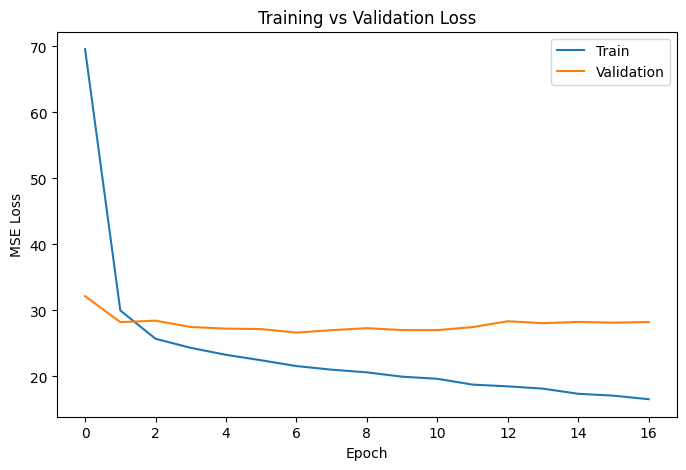

In [38]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [40]:
model.eval()
y_preds, y_true = [], []

with torch.no_grad():
    for x, y in test_reg_loader:
        y_preds.append(model(x).numpy())
        y_true.append(y.numpy())

y_preds = np.vstack(y_preds)
y_true = np.vstack(y_true)

print("MSE:", mean_squared_error(y_true, y_preds))
print("MAE:", mean_absolute_error(y_true, y_preds))
print("R²:", r2_score(y_true, y_preds))


MSE: 29.337549209594727
MAE: 3.3045992851257324
R²: 0.23813563585281372


In [ ]:
optimizers = {
    "SGD": optim.SGD(model.parameters(), lr=0.01),
    "SGD+Momentum": optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    "Adam": optim.Adam(model.parameters(), lr=0.001)
}
lrs = [1e-4, 1e-3, 1e-1]
configs = [
    {"hidden_layers": [32]},
    {"hidden_layers": [64, 64]},
    {"hidden_layers": [128, 128, 128]}
]

In [48]:
def run_experiment(
    config,
    optimizer_name="Adam",
    lr=1e-3,
    batch_size=32,
    epochs=100,
    weight_init="xavier",
    dropout=0.0,
    batch_norm=False
):
    # Data loaders
    train_loader = make_loader(train_reg, y_train_reg, batch_size, True)
    val_loader   = make_loader(val_reg, y_val_reg, batch_size, False)
    test_loader  = make_loader(test_reg, y_test_reg, batch_size, False)

    # Model
    model = MLP(
        input_dim=train_reg.shape[1],
        hidden_layers=config["hidden_layers"],
        activation=config.get("activation", "relu"),
        dropout=dropout,
        batch_norm=batch_norm
    )
    
    init_weights(model, weight_init)

    # Optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "SGD+Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.MSELoss()

    # Train
    train_losses, val_losses = train_model(
         model,
         optimizer,
         criterion,
         train_loader,
         val_loader,
         epochs=epochs,
         early_stopping=10,
         grad_clip=1.0
      )

    # Evaluate
    metrics = evaluate_model(model, test_loader)

    return {
        "config": config,
        "optimizer": optimizer_name,
        "lr": lr,
        "batch_size": batch_size,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "metrics": metrics
    }


In [49]:
optimizer_settings = {
    "SGD": 0.001,
    "SGD+Momentum": 0.001,
    "Adam": 0.001
}

results_optim = []

for opt, lr in optimizer_settings.items():
    print(f"\nRunning optimizer: {opt}, lr={lr}")
    result = run_experiment(
        config={"hidden_layers": [64, 64]},
        optimizer_name=opt,
        lr=lr
    )
    results_optim.append(result)



Running optimizer: SGD, lr=0.001
Epoch   1 | Train: 241.6582 | Val: 238.0676
Epoch   2 | Train: 229.9485 | Val: 226.4226
Epoch   3 | Train: 218.3897 | Val: 214.8059
Epoch   4 | Train: 206.9457 | Val: 202.9844
Epoch   5 | Train: 195.0645 | Val: 190.9260
Epoch   6 | Train: 183.2869 | Val: 178.6154
Epoch   7 | Train: 170.8632 | Val: 166.2194
Epoch   8 | Train: 158.7799 | Val: 154.0774
Epoch   9 | Train: 147.1240 | Val: 142.3979
Epoch  10 | Train: 135.9396 | Val: 131.3961
Epoch  11 | Train: 125.4155 | Val: 121.5320
Epoch  12 | Train: 116.4684 | Val: 112.8209
Epoch  13 | Train: 108.3946 | Val: 105.2392
Epoch  14 | Train: 101.4353 | Val: 98.9342
Epoch  15 | Train: 95.7930 | Val: 93.4681
Epoch  16 | Train: 90.7012 | Val: 88.9983
Epoch  17 | Train: 86.6780 | Val: 85.2578
Epoch  18 | Train: 83.2852 | Val: 82.1599
Epoch  19 | Train: 80.2779 | Val: 79.5149
Epoch  20 | Train: 77.8219 | Val: 77.3314
Epoch  21 | Train: 75.8787 | Val: 75.4553
Epoch  22 | Train: 73.7702 | Val: 73.7655
Epoch  23 | Tra

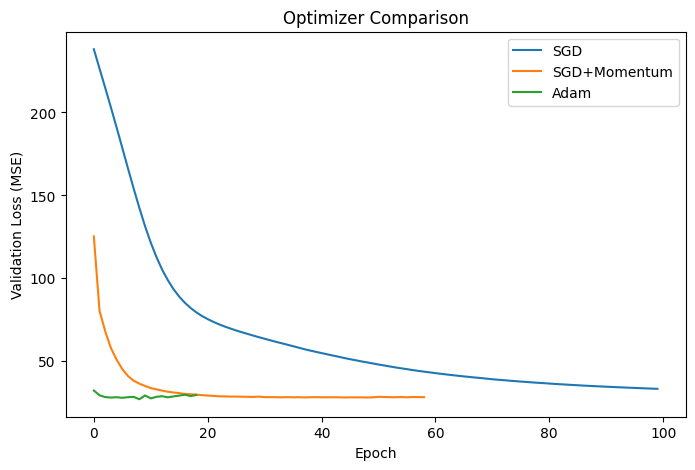

In [50]:
plt.figure(figsize=(8,5))
for r in results_optim:
    plt.plot(r["val_losses"], label=r["optimizer"])
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (MSE)")
plt.title("Optimizer Comparison")
plt.legend()
plt.show()


In [51]:
pd.DataFrame([
    {
        "Optimizer": r["optimizer"],
        "MSE": r["metrics"]["MSE"],
        "MAE": r["metrics"]["MAE"],
        "R2": r["metrics"]["R2"]
    }
    for r in results_optim
])


,Optimizer,MSE,MAE,R2
0,SGD,39.228050,3.515388,-0.018710
1,SGD+Momentum,28.989841,3.161120,0.247165
2,Adam,29.890900,3.317629,0.223766


In [52]:
# expriment with different learning rates
lrs = [1e-4, 1e-3, 1e-1]
results_lr = []

for lr in lrs:
    print(f"\nLearning rate: {lr}")
    r = run_experiment(
        config={"hidden_layers": [64, 64]},
        optimizer_name="Adam",
        lr=lr
    )
    results_lr.append(r)


Learning rate: 0.0001
Epoch   1 | Train: 194.3421 | Val: 159.0775
Epoch   2 | Train: 120.2803 | Val: 86.9417
Epoch   3 | Train: 62.1186 | Val: 48.3043
Epoch   4 | Train: 41.1659 | Val: 38.8452
Epoch   5 | Train: 35.2771 | Val: 35.6867
Epoch   6 | Train: 32.3291 | Val: 33.7366
Epoch   7 | Train: 30.2231 | Val: 32.4743
Epoch   8 | Train: 28.8517 | Val: 31.5065
Epoch   9 | Train: 27.7933 | Val: 30.7829
Epoch  10 | Train: 26.9405 | Val: 30.3144
Epoch  11 | Train: 26.2926 | Val: 29.9138
Epoch  12 | Train: 25.7711 | Val: 29.6091
Epoch  13 | Train: 25.3019 | Val: 29.4546
Epoch  14 | Train: 24.9458 | Val: 29.2673
Epoch  15 | Train: 24.5949 | Val: 29.1056
Epoch  16 | Train: 24.2305 | Val: 28.9433
Epoch  17 | Train: 24.0415 | Val: 28.8963
Epoch  18 | Train: 23.6519 | Val: 28.8688
Epoch  19 | Train: 23.4613 | Val: 28.6963
Epoch  20 | Train: 23.2234 | Val: 28.7416
Epoch  21 | Train: 22.9545 | Val: 28.8200
Epoch  22 | Train: 22.8572 | Val: 28.6344
Epoch  23 | Train: 22.6292 | Val: 28.6141
Epoch  2

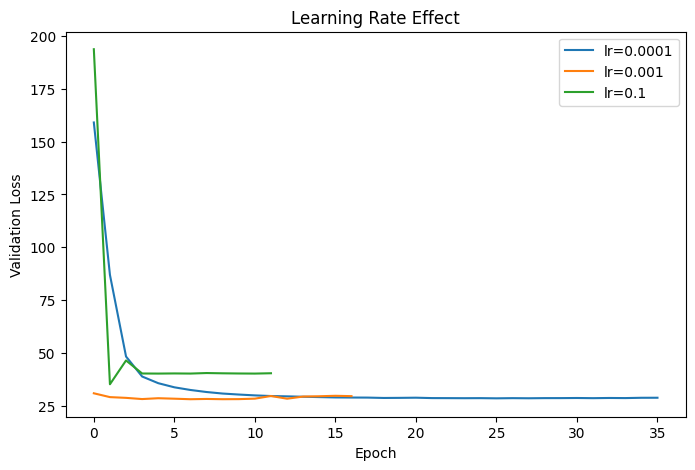

In [53]:
plt.figure(figsize=(8,5))
for r in results_lr:
    plt.plot(r["val_losses"], label=f"lr={r['lr']}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Learning Rate Effect")
plt.legend()
plt.show()


In [54]:
# expriment artuitectures
configs = [
    {"hidden_layers": [32]},
    {"hidden_layers": [64, 64]},
    {"hidden_layers": [128, 128, 128]}
]

results_arch = []

for cfg in configs:
    print(f"\nArchitecture: {cfg['hidden_layers']}")
    r = run_experiment(
        config=cfg,
        optimizer_name="Adam",
        lr=0.001
    )
    results_arch.append(r)



Architecture: [32]
Epoch   1 | Train: 169.8944 | Val: 79.9646
Epoch   2 | Train: 45.0403 | Val: 32.8486
Epoch   3 | Train: 30.2749 | Val: 30.5732
Epoch   4 | Train: 28.1450 | Val: 29.9067
Epoch   5 | Train: 26.7088 | Val: 29.1055
Epoch   6 | Train: 25.7954 | Val: 29.2591
Epoch   7 | Train: 25.2926 | Val: 28.6428
Epoch   8 | Train: 24.6260 | Val: 28.3927
Epoch   9 | Train: 24.1633 | Val: 28.2382
Epoch  10 | Train: 23.6286 | Val: 28.7763
Epoch  11 | Train: 23.3643 | Val: 28.3798
Epoch  12 | Train: 22.9058 | Val: 28.5108
Epoch  13 | Train: 22.6389 | Val: 28.3439
Epoch  14 | Train: 22.3085 | Val: 27.9090
Epoch  15 | Train: 21.9953 | Val: 27.8022
Epoch  16 | Train: 21.5400 | Val: 28.1415
Epoch  17 | Train: 21.3386 | Val: 27.8029
Epoch  18 | Train: 21.0895 | Val: 27.4654
Epoch  19 | Train: 20.7913 | Val: 27.9362
Epoch  20 | Train: 20.5393 | Val: 28.2571
Epoch  21 | Train: 20.2661 | Val: 28.1879
Epoch  22 | Train: 19.9819 | Val: 28.1640
Epoch  23 | Train: 19.9381 | Val: 27.6383
Epoch  24 | T

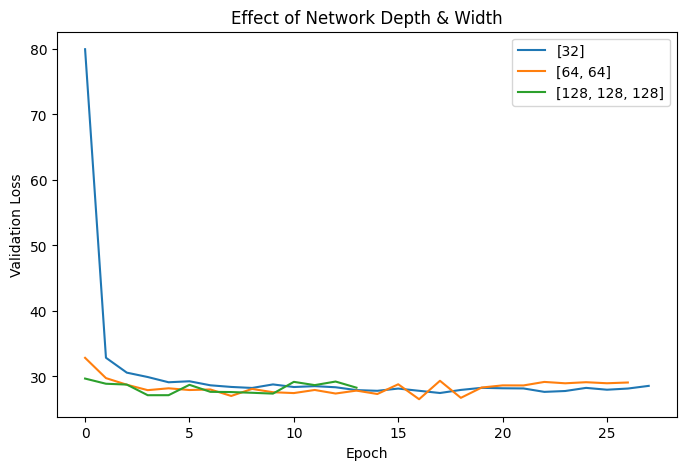

In [55]:
plt.figure(figsize=(8,5))
for r in results_arch:
    label = str(r["config"]["hidden_layers"])
    plt.plot(r["val_losses"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Effect of Network Depth & Width")
plt.legend()
plt.show()


In [56]:
pd.DataFrame([
    {
        "Architecture": r["config"]["hidden_layers"],
        "MSE": r["metrics"]["MSE"],
        "MAE": r["metrics"]["MAE"],
        "R2": r["metrics"]["R2"]
    }
    for r in results_arch
])


,Architecture,MSE,MAE,R2
0,[32],32.719936,3.306573,0.150299
1,"[64, 64]",32.560535,3.515274,0.154438
2,"[128, 128, 128]",29.497702,3.131219,0.233977


In [59]:
# Expriment with dropout
dropouts = [0.0,0.1, 0.3, 0.5]
results_dropout = []

for d in dropouts:
    print(f"\nDropout: {d}")
    r = run_experiment(
        config={"hidden_layers": [64, 64]},
        dropout=d
    )
    results_dropout.append(r)



Dropout: 0.0
Epoch   1 | Train: 66.7997 | Val: 31.7127
Epoch   2 | Train: 30.0722 | Val: 29.3363
Epoch   3 | Train: 26.4032 | Val: 28.6749
Epoch   4 | Train: 24.6122 | Val: 27.6131
Epoch   5 | Train: 23.4586 | Val: 28.2357
Epoch   6 | Train: 22.4065 | Val: 27.7390
Epoch   7 | Train: 21.9176 | Val: 27.2955
Epoch   8 | Train: 20.8668 | Val: 28.4616
Epoch   9 | Train: 20.4209 | Val: 27.8849
Epoch  10 | Train: 19.7133 | Val: 28.7929
Epoch  11 | Train: 19.3079 | Val: 28.6281
Epoch  12 | Train: 18.6352 | Val: 28.0560
Epoch  13 | Train: 18.2620 | Val: 27.7836
Epoch  14 | Train: 17.5357 | Val: 28.5511
Epoch  15 | Train: 17.0658 | Val: 28.5265
Epoch  16 | Train: 16.5292 | Val: 28.6957
Epoch  17 | Train: 16.1200 | Val: 30.3531
Early stopping triggered

Dropout: 0.1
Epoch   1 | Train: 67.8761 | Val: 31.7178
Epoch   2 | Train: 31.3725 | Val: 29.8759
Epoch   3 | Train: 28.6280 | Val: 29.4709
Epoch   4 | Train: 27.2162 | Val: 28.2854
Epoch   5 | Train: 25.9468 | Val: 28.0883
Epoch   6 | Train: 25.1

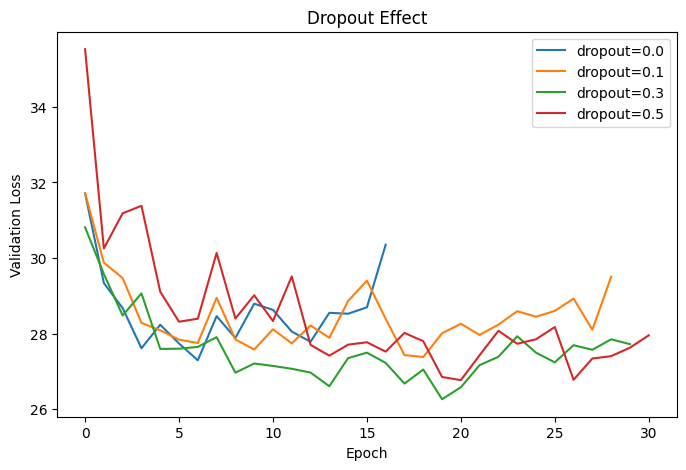

In [62]:
plt.figure(figsize=(8,5))
for i,r in enumerate(results_dropout):
    plt.plot(r["val_losses"], label=f"dropout={dropouts[i]}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Dropout Effect")
plt.legend()
plt.show()


### Experimental Analysis and Discussion (Regression Task)

This section discusses the impact of different training, optimization, architectural, and regularization choices on the performance of a Multilayer Perceptron (MLP) for a regression task. The goal of these experiments was not to find the best possible model, but to understand how different design decisions affect learning behavior and generalization.

---

### 1. Training and Optimization

#### Optimizer Choice
For a fixed learning rate and comparable validation performance, Adam consistently converged faster than the other optimizers. SGD with momentum performed better than plain SGD, but still required more epochs to reach similar validation loss. Plain SGD was the slowest and most sensitive to learning rate selection.

This behavior is expected since Adam adapts the learning rate for each parameter, which helps stabilize and accelerate training. Momentum improves SGD by smoothing updates, but it still lacks the adaptive nature of Adam.

**Summary:**  
Adam > SGD with momentum > SGD in terms of convergence speed.

---

#### Learning Rate
With a fixed optimizer (Adam), a learning rate of **0.001** provided the best trade-off between convergence speed and stability. A smaller learning rate (**0.0001**) resulted in much slower learning, requiring significantly more epochs to achieve similar performance. A large learning rate (**0.1**) caused training to diverge, leading to unstable loss values and poor validation performance.

This highlights the importance of learning rate tuning, as too small values slow down learning while too large values can cause numerical instability.

---

### 2. Architecture and Representation

#### Depth and Width
Increasing the depth and width of the network generally improved convergence speed. The deeper model with architecture **[128, 128, 128]** reached lower validation loss faster compared to **[64, 64]** and **[32]**. However, it also showed a higher tendency to overfit, with validation loss starting to increase after prolonged training.

The **[64, 64]** architecture provided a better balance between learning capacity and generalization, while the **[32]** network often underfit the data and converged more slowly.

**Summary:**  
- Larger networks learn faster and fit the data better  
- Smaller networks are more stable but may underfit  
- Medium-sized networks offer a good compromise

---

### 3. Regularization and Stability

#### Dropout
Dropout had a clear impact on overfitting behavior. When no dropout was used, the model tended to overfit quickly, with training loss decreasing while validation loss increased. Introducing dropout improved generalization.

A dropout rate of **0.3** resulted in the best validation performance, effectively reducing overfitting while maintaining good learning speed. A smaller value (**0.1**) also helped, but to a lesser extent. A high dropout rate (**0.5**) slowed down learning significantly, likely due to excessive information loss during training.

**Summary:**  
- No dropout → fast overfitting  
- Moderate dropout (0.3) → best generalization  
- High dropout (0.5) → slower learning

---

### Overall Observations

Across all experiments, the results show that:
- Optimization choices strongly affect training speed and stability
- Model capacity must be balanced to avoid overfitting
- Regularization techniques such as dropout are crucial for improving generalization

These experiments demonstrate how systematic changes to training and architecture parameters influence model behavior and performance, which is essential for understanding and designing deep learning models.


## Classification

In [103]:
# utils
def plot_loss_curves(experiment, title="Loss Curves"):
    plt.figure(figsize=(8,5))
    plt.plot(experiment["train_losses"], label="Train Loss")
    plt.plot(experiment["val_losses"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()
    
def print_metrics(experiment, name="Experiment"):
    print(f"\n{name}")
    for k, v in experiment["metrics"].items():
        print(f"{k}: {v:.4f}")
        
        
def compare_val_curves(experiments, labels, title="Validation Loss Comparison"):
    plt.figure(figsize=(8,5))
    for exp, label in zip(experiments, labels):
        plt.plot(exp["val_losses"], label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title(title)
    plt.legend()
    plt.show()


def print_metrics_table(experiments, param_name):
    rows = []
    for r in experiments:
        rows.append({
            param_name: r.get(param_name.lower(), "N/A"),
            "Accuracy": r["metrics"]["Accuracy"],
            "F1": r["metrics"]["F1"],
            "ROC-AUC": r["metrics"]["ROC-AUC"]
        })
    df = pd.DataFrame(rows)
    display(df)         
    
    
def plot_roc_curve(model, loader, title="ROC Curve"):
    model.eval()
    probs, y_true = [], []
    with torch.no_grad():
        for x, y in loader:
            logits = model(x)
            probs.append(torch.sigmoid(logits).numpy())
            y_true.append(y.numpy())
    probs = np.concatenate(probs)
    y_true = np.concatenate(y_true)
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()
    

    

In [39]:
BATCH_SIZE = 32

In [77]:
# split train test and validation data 

train_val, test = train_test_split(jobs, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42) 


print(len(train), len(val), len(test))


5625 1875 1875


In [78]:
# calculate average sallary and drop min_salary and max_salary for each one
# train
temp = (train['min_salary'] + train['max_salary']) /2

y_train = pd.Series(data=temp.values, index=temp.index,name="avg_salary")

train.drop(columns=['min_salary','max_salary'],inplace=True)

# val
temp = (val['min_salary'] + val['max_salary']) /2

y_val = pd.Series(data=temp.values, index=temp.index,name="avg_salary")

val.drop(columns=['min_salary','max_salary'],inplace=True)

# test
temp = (test['min_salary'] + test['max_salary']) /2

y_test = pd.Series(data=temp.values, index=temp.index,name="avg_salary")

test.drop(columns=['min_salary','max_salary'],inplace=True)


In [79]:
# convert salary float to labels

threshold = np.percentile(y_train, 80)   # top 20% threshold from training set only
print("High-salary threshold (80th percentile):", threshold)

y_train_cls = (y_train > threshold).astype(np.float32)
y_val_cls   = (y_val   > threshold).astype(np.float32)
y_test_cls  = (y_test  > threshold).astype(np.float32)

print("Train class distribution:", len(y_train_cls))
print("Val   class distribution:", len(y_val_cls))
print("Test  class distribution:", len(y_test_cls))

High-salary threshold (80th percentile): 17.5
Train class distribution: 5625
Val   class distribution: 1875
Test  class distribution: 1875


In [80]:
train_cls, val_cls, test_cls = train.copy(), val.copy(), test.copy()

In [81]:
# featue scaling
scaler = StandardScaler()

train_cls = scaler.fit_transform(train_cls)
val_cls = scaler.transform(val_cls)
test_cls = scaler.transform(test_cls)


y_train_cls = y_train_cls.values.reshape(-1)
y_val_cls   = y_val_cls.values.reshape(-1)
y_test_cls  = y_test_cls.values.reshape(-1)

In [82]:
def make_loader(X, y, batch_size=32, shuffle=True):
    # Convert X to float32 numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values.astype(np.float32)
    else:
        X = X.astype(np.float32)

    # Ensure y is 1D float32 numpy array
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y = y.values
    y = y.astype(np.float32)
    if y.ndim > 1:
        y = y.reshape(-1)

    dataset = TensorDataset(
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)




BATCH_SIZE = 32

train_loader = make_loader(train_cls, y_train_cls, BATCH_SIZE, True)
val_loader   = make_loader(val_cls, y_val_cls, BATCH_SIZE, False)
test_loader  = make_loader(test_cls, y_test_cls, BATCH_SIZE, False)

In [83]:
class MLPClassifier(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_layers=[64, 64],
        activation="relu",
        dropout=0.0,
        batch_norm=False
    ):
        super().__init__()

        layers = []
        prev_dim = input_dim

        activations = {
            "relu": nn.ReLU(),
            "leakyrelu": nn.LeakyReLU(0.1),
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid()
        }

        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))

            if batch_norm:
                layers.append(nn.BatchNorm1d(h))

            layers.append(activations[activation])

            if dropout > 0:
                layers.append(nn.Dropout(dropout))

            prev_dim = h

        layers.append(nn.Linear(prev_dim, 1))  # logits
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)  # ensure shape (batch,)


In [84]:
def init_weights(model, method="xavier"):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if method == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif method == "he":
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            elif method == "random":
                nn.init.normal_(m.weight, mean=0, std=0.01)


In [95]:
def train_classifier(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    epochs=100,
    early_stopping=10,
    grad_clip=None
):
    train_losses, val_losses = [], []
    best_val = float("inf")
    patience = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for x, y in train_loader:
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                val_loss += criterion(model(x), y).item()
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= early_stopping:
                print("Early stopping triggered")
                break

    return train_losses, val_losses


In [96]:
# Evaluate classifier
def evaluate_classifier(model, loader):
    model.eval()
    probs, y_true = [], []

    with torch.no_grad():
        for x, y in loader:
            logits = model(x)
            probs.append(torch.sigmoid(model(x)).numpy())
            y_true.append(y.numpy())

    probs = np.concatenate(probs)
    y_true = np.concatenate(y_true)
    preds = (probs >= 0.5).astype(int)

    return {
        "Accuracy": accuracy_score(y_true, preds),
        "Precision": precision_score(y_true, preds),
        "Recall": recall_score(y_true, preds),
        "F1": f1_score(y_true, preds),
        "ROC-AUC": roc_auc_score(y_true, probs)
    }


In [97]:
# baseline classifier
model = MLPClassifier(
    input_dim=train_cls.shape[1],
    hidden_layers=[64, 64],
    activation="relu"
)

init_weights(model, "xavier")

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = train_classifier(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    epochs=100,
    grad_clip=1.0
)


Epoch   1 | Train: 0.3118 | Val: 0.2615
Epoch   2 | Train: 0.2294 | Val: 0.2661
Epoch   3 | Train: 0.1969 | Val: 0.2823
Epoch   4 | Train: 0.1803 | Val: 0.2899
Epoch   5 | Train: 0.1601 | Val: 0.3138
Epoch   6 | Train: 0.1494 | Val: 0.3282
Epoch   7 | Train: 0.1337 | Val: 0.3611
Epoch   8 | Train: 0.1231 | Val: 0.3732
Epoch   9 | Train: 0.1113 | Val: 0.4088
Epoch  10 | Train: 0.1042 | Val: 0.4447
Epoch  11 | Train: 0.0943 | Val: 0.4648
Early stopping triggered


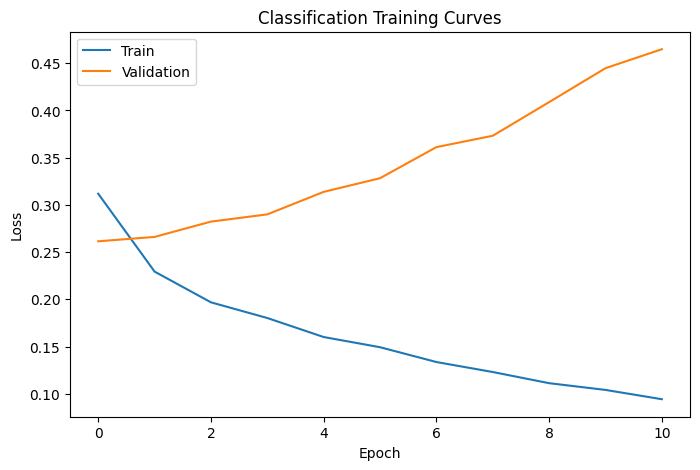

In [98]:
# baseline results
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Classification Training Curves")
plt.show()


In [99]:
metrics = evaluate_classifier(model, test_loader)
pd.DataFrame([metrics])

,Accuracy,Precision,Recall,F1,ROC-AUC
0,0.889067,0.44186,0.295337,0.354037,0.713971


In [100]:
def run_classification_experiment(
    config,
    optimizer_name="Adam",
    lr=0.001,
    batch_size=32,
    weight_init="xavier",
    dropout=0.0,
    batch_norm=False,
    l2_reg=0.0,
    epochs=100,
    early_stopping_patience=10,
    grad_clip=1.0
):
    # Data loaders
    train_loader = make_loader(train_cls, y_train_cls, batch_size, True)
    val_loader = make_loader(val_cls, y_val_cls, batch_size, False)
    test_loader = make_loader(test_cls, y_test_cls, batch_size, False)

    # Model
    model = MLPClassifier(
        input_dim=train_cls.shape[1],
        hidden_layers=config["hidden_layers"],
        activation=config.get("activation", "relu"),
        dropout=dropout,
        batch_norm=batch_norm
    )
    init_weights(model, weight_init)

    # Optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_reg)
    elif optimizer_name == "SGD+Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=l2_reg)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)

    criterion = nn.BCEWithLogitsLoss()

    # Train
    train_losses, val_losses = train_classifier(
        model,
        optimizer,
        criterion,
        train_loader,
        val_loader,
        epochs=epochs,
        early_stopping=early_stopping_patience,
        grad_clip=grad_clip
    )

    # Evaluate
    metrics = evaluate_classifier(model, test_loader)

    return {
        "config": config,
        "optimizer": optimizer_name,
        "lr": lr,
        "batch_size": batch_size,
        "weight_init": weight_init,
        "dropout": dropout,
        "batch_norm": batch_norm,
        "l2_reg": l2_reg,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "metrics": metrics
    }


In [108]:
# experiment with different optimizers
optimizer_settings = {
    "SGD": 0.0001,          # very small for stability
    "SGD+Momentum": 0.0001,
    "Adam": 0.0001
}

results_opt = []

for opt, lr in optimizer_settings.items():
    print(f"\nRunning optimizer: {opt}, lr={lr}")
    r = run_classification_experiment(
        config={"hidden_layers": [64, 64]},
        optimizer_name=opt,
        lr=lr,
        early_stopping_patience=10,
        grad_clip=1.0
    )
    results_opt.append(r)



Running optimizer: SGD, lr=0.0001
Epoch   1 | Train: 0.7571 | Val: 0.7550
Epoch   2 | Train: 0.7406 | Val: 0.7381
Epoch   3 | Train: 0.7247 | Val: 0.7217
Epoch   4 | Train: 0.7094 | Val: 0.7059
Epoch   5 | Train: 0.6948 | Val: 0.6908
Epoch   6 | Train: 0.6808 | Val: 0.6765
Epoch   7 | Train: 0.6674 | Val: 0.6627
Epoch   8 | Train: 0.6546 | Val: 0.6494
Epoch   9 | Train: 0.6423 | Val: 0.6368
Epoch  10 | Train: 0.6304 | Val: 0.6248
Epoch  11 | Train: 0.6192 | Val: 0.6133
Epoch  12 | Train: 0.6085 | Val: 0.6024
Epoch  13 | Train: 0.5984 | Val: 0.5920
Epoch  14 | Train: 0.5886 | Val: 0.5820
Epoch  15 | Train: 0.5796 | Val: 0.5726
Epoch  16 | Train: 0.5709 | Val: 0.5636
Epoch  17 | Train: 0.5621 | Val: 0.5551
Epoch  18 | Train: 0.5541 | Val: 0.5470
Epoch  19 | Train: 0.5467 | Val: 0.5394
Epoch  20 | Train: 0.5394 | Val: 0.5321
Epoch  21 | Train: 0.5325 | Val: 0.5250
Epoch  22 | Train: 0.5259 | Val: 0.5185
Epoch  23 | Train: 0.5201 | Val: 0.5122
Epoch  24 | Train: 0.5140 | Val: 0.5063
Epoch

d:\Khatam\5\ADS\Assignments\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch   1 | Train: 0.5264 | Val: 0.4985
Epoch   2 | Train: 0.4775 | Val: 0.4608
Epoch   3 | Train: 0.4481 | Val: 0.4373
Epoch   4 | Train: 0.4283 | Val: 0.4220
Epoch   5 | Train: 0.4153 | Val: 0.4117
Epoch   6 | Train: 0.4061 | Val: 0.4039
Epoch   7 | Train: 0.3991 | Val: 0.3979
Epoch   8 | Train: 0.3930 | Val: 0.3931
Epoch   9 | Train: 0.3883 | Val: 0.3890
Epoch  10 | Train: 0.3839 | Val: 0.3853
Epoch  11 | Train: 0.3795 | Val: 0.3820
Epoch  12 | Train: 0.3761 | Val: 0.3788
Epoch  13 | Train: 0.3727 | Val: 0.3759
Epoch  14 | Train: 0.3686 | Val: 0.3731
Epoch  15 | Train: 0.3657 | Val: 0.3705
Epoch  16 | Train: 0.3621 | Val: 0.3679
Epoch  17 | Train: 0.3586 | Val: 0.3654
Epoch  18 | Train: 0.3559 | Val: 0.3630
Epoch  19 | Train: 0.3528 | Val: 0.3605
Epoch  20 | Train: 0.3499 | Val: 0.3582
Epoch  21 | Train: 0.3464 | Val: 0.3560
Epoch  22 | Train: 0.3437 | Val: 0.3539
Epoch  23 | Train: 0.3411 | Val: 0.3517
Epoch  24 | Train: 0.3381 | Val: 0.3496
Epoch  25 | Train: 0.3355 | Val: 0.3475


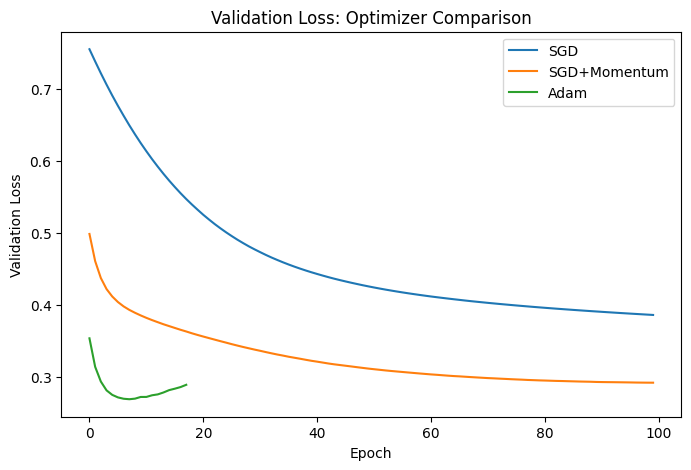

,Optimizer,Final Train Loss,Final Val Loss,Accuracy,F1,ROC-AUC
0,SGD,0.391205,0.386005,0.897067,0.000000,0.500861
1,SGD+Momentum,0.227006,0.291924,0.904000,0.217391,0.769127
2,Adam,0.173838,0.289005,0.905067,0.320611,0.779760


In [109]:
# Plot validation loss curves for optimizer comparison
labels = [r['optimizer'] for r in results_opt]
compare_val_curves(results_opt, labels, title="Validation Loss: Optimizer Comparison")

# Print metrics table
df_opt_metrics = pd.DataFrame([
    {
        "Optimizer": r["optimizer"],
        "Final Train Loss": r["train_losses"][-1],
        "Final Val Loss": r["val_losses"][-1],
        "Accuracy": r["metrics"]["Accuracy"],
        "F1": r["metrics"]["F1"],
        "ROC-AUC": r["metrics"]["ROC-AUC"]
    }
    for r in results_opt
])
display(df_opt_metrics)


In [110]:
# Learning rate variations
lrs = [0.0001, 0.001, 0.1]
results_lr = []

for lr in lrs:
    print(f"Running learning rate: {lr}")
    r = run_classification_experiment(
        config={"hidden_layers": [64, 64]},
        optimizer_name="Adam",
        lr=lr
    )
    results_lr.append(r)


Running learning rate: 0.0001
Epoch   1 | Train: 0.4547 | Val: 0.3745
Epoch   2 | Train: 0.3654 | Val: 0.3346
Epoch   3 | Train: 0.3247 | Val: 0.3093
Epoch   4 | Train: 0.2949 | Val: 0.2966
Epoch   5 | Train: 0.2741 | Val: 0.2889
Epoch   6 | Train: 0.2569 | Val: 0.2811
Epoch   7 | Train: 0.2423 | Val: 0.2787
Epoch   8 | Train: 0.2305 | Val: 0.2764
Epoch   9 | Train: 0.2212 | Val: 0.2764
Epoch  10 | Train: 0.2136 | Val: 0.2759
Epoch  11 | Train: 0.2068 | Val: 0.2772
Epoch  12 | Train: 0.2008 | Val: 0.2780
Epoch  13 | Train: 0.1962 | Val: 0.2795
Epoch  14 | Train: 0.1919 | Val: 0.2811
Epoch  15 | Train: 0.1875 | Val: 0.2836
Epoch  16 | Train: 0.1836 | Val: 0.2843
Epoch  17 | Train: 0.1803 | Val: 0.2862
Epoch  18 | Train: 0.1772 | Val: 0.2881
Epoch  19 | Train: 0.1742 | Val: 0.2906
Epoch  20 | Train: 0.1713 | Val: 0.2928
Early stopping triggered
Running learning rate: 0.001
Epoch   1 | Train: 0.3169 | Val: 0.2725
Epoch   2 | Train: 0.2313 | Val: 0.2673
Epoch   3 | Train: 0.2017 | Val: 0.2

d:\Khatam\5\ADS\Assignments\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


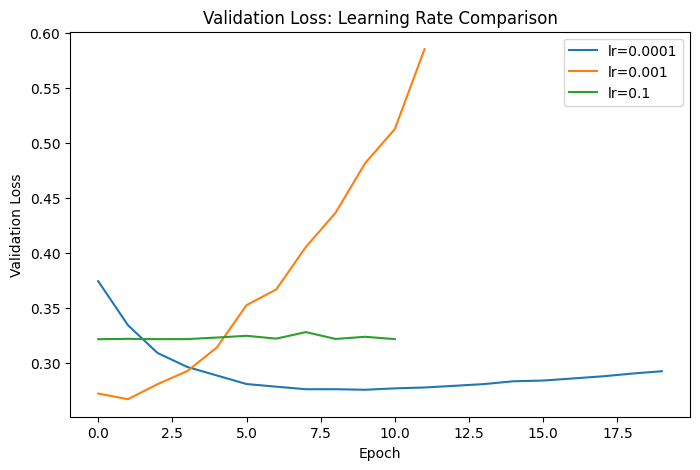

,Learning Rate,Final Train Loss,Final Val Loss,Accuracy,F1,ROC-AUC
0,0.0001,0.171302,0.292753,0.902400,0.324723,0.780145
1,0.0010,0.092356,0.584918,0.885867,0.381503,0.728572
2,0.1000,0.328577,0.321858,0.897067,0.000000,0.500000


In [111]:
# Plot validation loss curves for learning rate comparison
labels = [f"lr={r['lr']}" for r in results_lr]
compare_val_curves(results_lr, labels, title="Validation Loss: Learning Rate Comparison")

# Print metrics table
df_lr_metrics = pd.DataFrame([
    {
        "Learning Rate": r["lr"],
        "Final Train Loss": r["train_losses"][-1],
        "Final Val Loss": r["val_losses"][-1],
        "Accuracy": r["metrics"]["Accuracy"],
        "F1": r["metrics"]["F1"],
        "ROC-AUC": r["metrics"]["ROC-AUC"]
    }
    for r in results_lr
])
display(df_lr_metrics)


In [112]:
# Batch size effects
batch_sizes = [16, 32, 64]
results_batch = []

for bs in batch_sizes:
    print(f"Running batch size: {bs}")
    r = run_classification_experiment(
        config={"hidden_layers": [64, 64]},
        optimizer_name="Adam",
        lr=0.001,
        batch_size=bs
    )
    results_batch.append(r)


Running batch size: 16
Epoch   1 | Train: 0.3113 | Val: 0.2705
Epoch   2 | Train: 0.2290 | Val: 0.2695
Epoch   3 | Train: 0.1961 | Val: 0.2751
Epoch   4 | Train: 0.1758 | Val: 0.3088
Epoch   5 | Train: 0.1585 | Val: 0.3136
Epoch   6 | Train: 0.1436 | Val: 0.3454
Epoch   7 | Train: 0.1319 | Val: 0.3881
Epoch   8 | Train: 0.1174 | Val: 0.4236
Epoch   9 | Train: 0.1066 | Val: 0.4758
Epoch  10 | Train: 0.0967 | Val: 0.5264
Epoch  11 | Train: 0.0918 | Val: 0.5757
Epoch  12 | Train: 0.0796 | Val: 0.6475
Early stopping triggered
Running batch size: 32
Epoch   1 | Train: 0.3083 | Val: 0.2683
Epoch   2 | Train: 0.2285 | Val: 0.2655
Epoch   3 | Train: 0.1973 | Val: 0.2779
Epoch   4 | Train: 0.1799 | Val: 0.2860
Epoch   5 | Train: 0.1618 | Val: 0.3147
Epoch   6 | Train: 0.1493 | Val: 0.3433
Epoch   7 | Train: 0.1367 | Val: 0.3728
Epoch   8 | Train: 0.1259 | Val: 0.4031
Epoch   9 | Train: 0.1165 | Val: 0.4338
Epoch  10 | Train: 0.1050 | Val: 0.4713
Epoch  11 | Train: 0.0990 | Val: 0.5092
Epoch  12

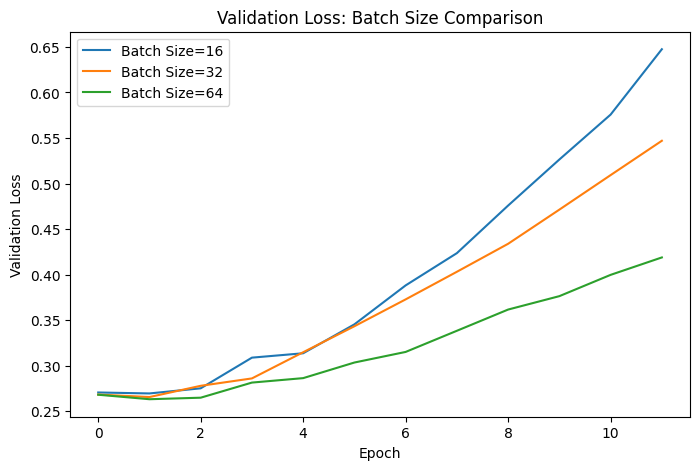

,Batch Size,Final Train Loss,Final Val Loss,Accuracy,F1,ROC-AUC
0,16,0.079574,0.647481,0.881067,0.368272,0.738705
1,32,0.091513,0.546957,0.887467,0.373887,0.719457
2,64,0.107612,0.418835,0.896000,0.325260,0.729731


In [113]:
labels = [f"Batch Size={r['batch_size']}" for r in results_batch]
compare_val_curves(results_batch, labels, title="Validation Loss: Batch Size Comparison")

df_batch_metrics = pd.DataFrame([
    {
        "Batch Size": r["batch_size"],
        "Final Train Loss": r["train_losses"][-1],
        "Final Val Loss": r["val_losses"][-1],
        "Accuracy": r["metrics"]["Accuracy"],
        "F1": r["metrics"]["F1"],
        "ROC-AUC": r["metrics"]["ROC-AUC"]
    }
    for r in results_batch
])
display(df_batch_metrics)


In [114]:
# Depth & Width
configs = [
    {"hidden_layers": [32]},
    {"hidden_layers": [64, 64]},
    {"hidden_layers": [128, 128, 128]}
]
results_arch = []

for cfg in configs:
    print(f"Running architecture: {cfg['hidden_layers']}")
    r = run_classification_experiment(
        config=cfg,
        optimizer_name="Adam",
        lr=0.001
    )
    results_arch.append(r)

Running architecture: [32]
Epoch   1 | Train: 0.5038 | Val: 0.2877
Epoch   2 | Train: 0.2856 | Val: 0.2560
Epoch   3 | Train: 0.2348 | Val: 0.2570
Epoch   4 | Train: 0.2121 | Val: 0.2626
Epoch   5 | Train: 0.1994 | Val: 0.2737
Epoch   6 | Train: 0.1899 | Val: 0.2804
Epoch   7 | Train: 0.1817 | Val: 0.2889
Epoch   8 | Train: 0.1754 | Val: 0.2996
Epoch   9 | Train: 0.1682 | Val: 0.3047
Epoch  10 | Train: 0.1625 | Val: 0.3159
Epoch  11 | Train: 0.1561 | Val: 0.3239
Epoch  12 | Train: 0.1499 | Val: 0.3354
Early stopping triggered
Running architecture: [64, 64]
Epoch   1 | Train: 0.3191 | Val: 0.2654
Epoch   2 | Train: 0.2325 | Val: 0.2721
Epoch   3 | Train: 0.2007 | Val: 0.2833
Epoch   4 | Train: 0.1811 | Val: 0.2949
Epoch   5 | Train: 0.1652 | Val: 0.3261
Epoch   6 | Train: 0.1519 | Val: 0.3384
Epoch   7 | Train: 0.1383 | Val: 0.3603
Epoch   8 | Train: 0.1288 | Val: 0.3805
Epoch   9 | Train: 0.1170 | Val: 0.4054
Epoch  10 | Train: 0.1085 | Val: 0.4304
Epoch  11 | Train: 0.0987 | Val: 0.47

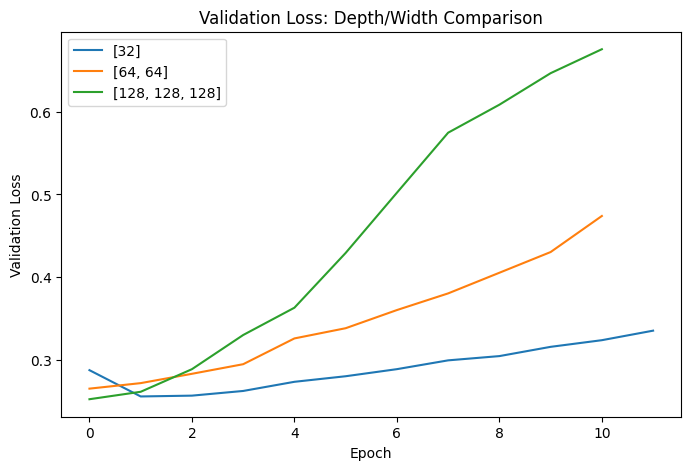

,Architecture,Final Train Loss,Final Val Loss,Accuracy,F1,ROC-AUC
0,[32],0.149915,0.335444,0.907733,0.375451,0.784378
1,"[64, 64]",0.098705,0.473957,0.893333,0.342105,0.740715
2,"[128, 128, 128]",0.061799,0.675381,0.868800,0.345745,0.718796


In [115]:
labels = [str(r["config"]["hidden_layers"]) for r in results_arch]
compare_val_curves(results_arch, labels, title="Validation Loss: Depth/Width Comparison")

df_arch_metrics = pd.DataFrame([
    {
        "Architecture": r["config"]["hidden_layers"],
        "Final Train Loss": r["train_losses"][-1],
        "Final Val Loss": r["val_losses"][-1],
        "Accuracy": r["metrics"]["Accuracy"],
        "F1": r["metrics"]["F1"],
        "ROC-AUC": r["metrics"]["ROC-AUC"]
    }
    for r in results_arch
])
display(df_arch_metrics)


In [117]:
# Activation functions
activations = ["relu", "leakyrelu", "tanh", "sigmoid"]
results_act = []

for act in activations:
    print(f"Running activation: {act}")
    r = run_classification_experiment(
        config={"hidden_layers":[64,64], "activation": act},
        optimizer_name="Adam",
        lr=0.001,
    )
    results_act.append(r)


Running activation: relu
Epoch   1 | Train: 0.3326 | Val: 0.2700
Epoch   2 | Train: 0.2328 | Val: 0.2688
Epoch   3 | Train: 0.2006 | Val: 0.2789
Epoch   4 | Train: 0.1811 | Val: 0.2981
Epoch   5 | Train: 0.1691 | Val: 0.3192
Epoch   6 | Train: 0.1548 | Val: 0.3429
Epoch   7 | Train: 0.1401 | Val: 0.3633
Epoch   8 | Train: 0.1282 | Val: 0.4002
Epoch   9 | Train: 0.1202 | Val: 0.4293
Epoch  10 | Train: 0.1100 | Val: 0.4648
Epoch  11 | Train: 0.1003 | Val: 0.4977
Epoch  12 | Train: 0.0933 | Val: 0.5300
Early stopping triggered
Running activation: leakyrelu
Epoch   1 | Train: 0.3545 | Val: 0.2788
Epoch   2 | Train: 0.2355 | Val: 0.2729
Epoch   3 | Train: 0.2071 | Val: 0.2877
Epoch   4 | Train: 0.1873 | Val: 0.3052
Epoch   5 | Train: 0.1721 | Val: 0.3222
Epoch   6 | Train: 0.1642 | Val: 0.3355
Epoch   7 | Train: 0.1511 | Val: 0.3633
Epoch   8 | Train: 0.1408 | Val: 0.4008
Epoch   9 | Train: 0.1345 | Val: 0.4147
Epoch  10 | Train: 0.1225 | Val: 0.4675
Epoch  11 | Train: 0.1146 | Val: 0.4836


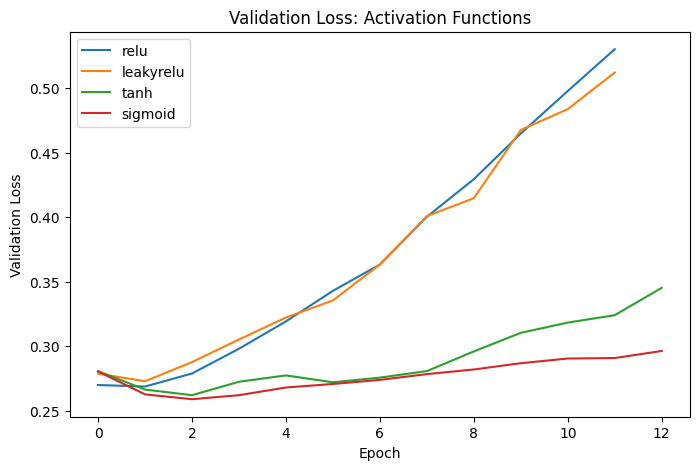

,Activation,Final Train Loss,Final Val Loss,Accuracy,F1,ROC-AUC
0,relu,0.093287,0.530017,0.897600,0.342466,0.723554
1,leakyrelu,0.107038,0.511977,0.896533,0.378205,0.747228
2,tanh,0.110981,0.345244,0.896533,0.393750,0.791220
3,sigmoid,0.193439,0.296325,0.900267,0.343860,0.769675


In [118]:
labels = [r["config"]["activation"] for r in results_act]
compare_val_curves(results_act, labels, title="Validation Loss: Activation Functions")

df_act_metrics = pd.DataFrame([
    {
        "Activation": r["config"]["activation"],
        "Final Train Loss": r["train_losses"][-1],
        "Final Val Loss": r["val_losses"][-1],
        "Accuracy": r["metrics"]["Accuracy"],
        "F1": r["metrics"]["F1"],
        "ROC-AUC": r["metrics"]["ROC-AUC"]
    }
    for r in results_act
])
display(df_act_metrics)


In [119]:
# Weight initialization
inits = ["xavier", "he", "random"]
results_init = []

for w_init in inits:
    print(f"Running weight init: {w_init}")
    r = run_classification_experiment(
        config={"hidden_layers": [64, 64]},
        optimizer_name="Adam",
        lr=0.001,
        weight_init=w_init
    )
    results_init.append(r)

Running weight init: xavier
Epoch   1 | Train: 0.3368 | Val: 0.2758
Epoch   2 | Train: 0.2355 | Val: 0.2690
Epoch   3 | Train: 0.2023 | Val: 0.2840
Epoch   4 | Train: 0.1810 | Val: 0.2986
Epoch   5 | Train: 0.1663 | Val: 0.3221
Epoch   6 | Train: 0.1522 | Val: 0.3503
Epoch   7 | Train: 0.1394 | Val: 0.3695
Epoch   8 | Train: 0.1253 | Val: 0.4034
Epoch   9 | Train: 0.1161 | Val: 0.4519
Epoch  10 | Train: 0.1055 | Val: 0.4857
Epoch  11 | Train: 0.0973 | Val: 0.5134
Epoch  12 | Train: 0.0873 | Val: 0.5484
Early stopping triggered
Running weight init: he
Epoch   1 | Train: 0.3409 | Val: 0.2794
Epoch   2 | Train: 0.2334 | Val: 0.2688
Epoch   3 | Train: 0.1960 | Val: 0.2768
Epoch   4 | Train: 0.1780 | Val: 0.2889
Epoch   5 | Train: 0.1608 | Val: 0.3072
Epoch   6 | Train: 0.1447 | Val: 0.3264
Epoch   7 | Train: 0.1332 | Val: 0.3401
Epoch   8 | Train: 0.1222 | Val: 0.3774
Epoch   9 | Train: 0.1114 | Val: 0.3967
Epoch  10 | Train: 0.1008 | Val: 0.4085
Epoch  11 | Train: 0.0941 | Val: 0.4457
Epo

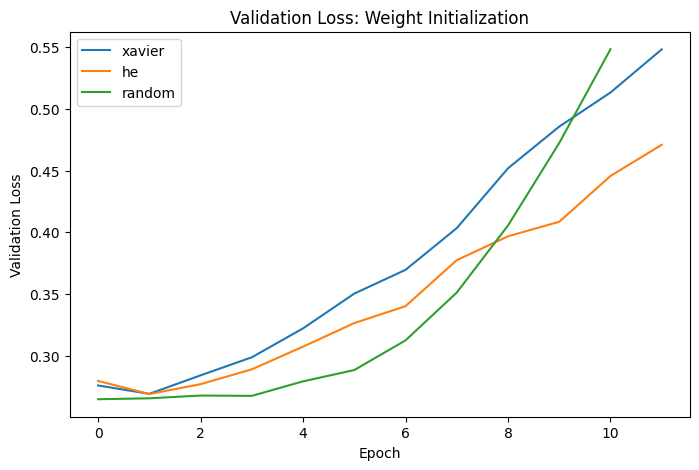

,Weight Init,Final Train Loss,Final Val Loss,Accuracy,F1,ROC-AUC
0,xavier,0.087281,0.548372,0.895467,0.359477,0.751788
1,he,0.087111,0.470975,0.898133,0.339100,0.729774
2,random,0.133718,0.548488,0.901333,0.341637,0.733556


In [120]:
labels = [r['weight_init'] for r in results_init]
compare_val_curves(results_init, labels, title="Validation Loss: Weight Initialization")

# Metrics table
df_init_metrics = pd.DataFrame([
    {
        "Weight Init": r["weight_init"],
        "Final Train Loss": r["train_losses"][-1],
        "Final Val Loss": r["val_losses"][-1],
        "Accuracy": r["metrics"]["Accuracy"],
        "F1": r["metrics"]["F1"],
        "ROC-AUC": r["metrics"]["ROC-AUC"]
    }
    for r in results_init
])
display(df_init_metrics)

In [121]:
# Batch normalization
results_bn = []
for bn in [False, True]:
    print(f"Running batch norm: {bn}")
    r = run_classification_experiment(
        config={"hidden_layers": [64, 64]},
        optimizer_name="Adam",
        lr=0.001,
        batch_norm=bn
    )
    results_bn.append(r)

Running batch norm: False
Epoch   1 | Train: 0.3227 | Val: 0.2733
Epoch   2 | Train: 0.2303 | Val: 0.2845
Epoch   3 | Train: 0.1968 | Val: 0.3028
Epoch   4 | Train: 0.1763 | Val: 0.3123
Epoch   5 | Train: 0.1625 | Val: 0.3332
Epoch   6 | Train: 0.1481 | Val: 0.3631
Epoch   7 | Train: 0.1349 | Val: 0.4088
Epoch   8 | Train: 0.1232 | Val: 0.4274
Epoch   9 | Train: 0.1137 | Val: 0.4647
Epoch  10 | Train: 0.1034 | Val: 0.5056
Epoch  11 | Train: 0.0950 | Val: 0.5592
Early stopping triggered
Running batch norm: True
Epoch   1 | Train: 0.4768 | Val: 0.2846
Epoch   2 | Train: 0.2466 | Val: 0.2656
Epoch   3 | Train: 0.2192 | Val: 0.2789
Epoch   4 | Train: 0.2025 | Val: 0.2777
Epoch   5 | Train: 0.1914 | Val: 0.2852
Epoch   6 | Train: 0.1772 | Val: 0.3079
Epoch   7 | Train: 0.1716 | Val: 0.3097
Epoch   8 | Train: 0.1586 | Val: 0.3154
Epoch   9 | Train: 0.1514 | Val: 0.3082
Epoch  10 | Train: 0.1448 | Val: 0.3237
Epoch  11 | Train: 0.1369 | Val: 0.3266
Epoch  12 | Train: 0.1314 | Val: 0.3521
Earl

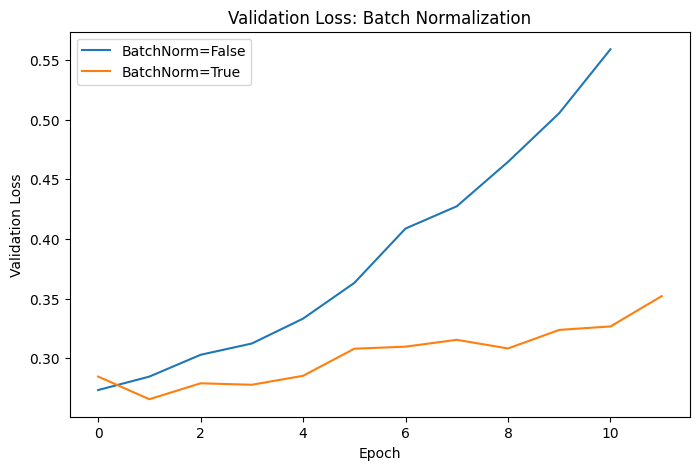

,BatchNorm,Final Train Loss,Final Val Loss,Accuracy,F1,ROC-AUC
0,False,0.095017,0.559203,0.884267,0.385269,0.760792
1,True,0.131388,0.352084,0.900800,0.354167,0.752535


In [122]:
labels = [f"BatchNorm={r['batch_norm']}" for r in results_bn]
compare_val_curves(results_bn, labels, title="Validation Loss: Batch Normalization")

df_bn_metrics = pd.DataFrame([
    {
        "BatchNorm": r["batch_norm"],
        "Final Train Loss": r["train_losses"][-1],
        "Final Val Loss": r["val_losses"][-1],
        "Accuracy": r["metrics"]["Accuracy"],
        "F1": r["metrics"]["F1"],
        "ROC-AUC": r["metrics"]["ROC-AUC"]
    }
    for r in results_bn
])
display(df_bn_metrics)


In [123]:
# Dropout
dropouts = [0.0, 0.1, 0.3, 0.5]
results_dropout = []

for d in dropouts:
    print(f"Running dropout: {d}")
    r = run_classification_experiment(
        config={"hidden_layers": [64, 64]},
        optimizer_name="Adam",
        lr=0.001,
        dropout=d
    )
    results_dropout.append(r)


Running dropout: 0.0
Epoch   1 | Train: 0.3267 | Val: 0.2674
Epoch   2 | Train: 0.2316 | Val: 0.2724
Epoch   3 | Train: 0.2019 | Val: 0.2807
Epoch   4 | Train: 0.1838 | Val: 0.2855
Epoch   5 | Train: 0.1668 | Val: 0.3138
Epoch   6 | Train: 0.1550 | Val: 0.3301
Epoch   7 | Train: 0.1417 | Val: 0.3646
Epoch   8 | Train: 0.1304 | Val: 0.3891
Epoch   9 | Train: 0.1200 | Val: 0.4302
Epoch  10 | Train: 0.1120 | Val: 0.4506
Epoch  11 | Train: 0.1025 | Val: 0.4936
Early stopping triggered
Running dropout: 0.1
Epoch   1 | Train: 0.3429 | Val: 0.2599
Epoch   2 | Train: 0.2510 | Val: 0.2630
Epoch   3 | Train: 0.2164 | Val: 0.2746
Epoch   4 | Train: 0.1972 | Val: 0.2926
Epoch   5 | Train: 0.1867 | Val: 0.3113
Epoch   6 | Train: 0.1760 | Val: 0.3399
Epoch   7 | Train: 0.1629 | Val: 0.3814
Epoch   8 | Train: 0.1550 | Val: 0.3951
Epoch   9 | Train: 0.1487 | Val: 0.4205
Epoch  10 | Train: 0.1352 | Val: 0.4715
Epoch  11 | Train: 0.1292 | Val: 0.4852
Early stopping triggered
Running dropout: 0.3
Epoch  

In [124]:
def visualize_experiment(experiments, param_name, title="Validation Loss Comparison"):
    labels = [str(r.get(param_name.lower(), "N/A")) for r in experiments]
    compare_val_curves(experiments, labels, title=title)

    df_metrics = pd.DataFrame([
        {
            param_name: r.get(param_name.lower(), "N/A"),
            "Final Train Loss": r["train_losses"][-1],
            "Final Val Loss": r["val_losses"][-1],
            "Accuracy": r["metrics"]["Accuracy"],
            "F1": r["metrics"]["F1"],
            "ROC-AUC": r["metrics"]["ROC-AUC"]
        }
        for r in experiments
    ])
    display(df_metrics)

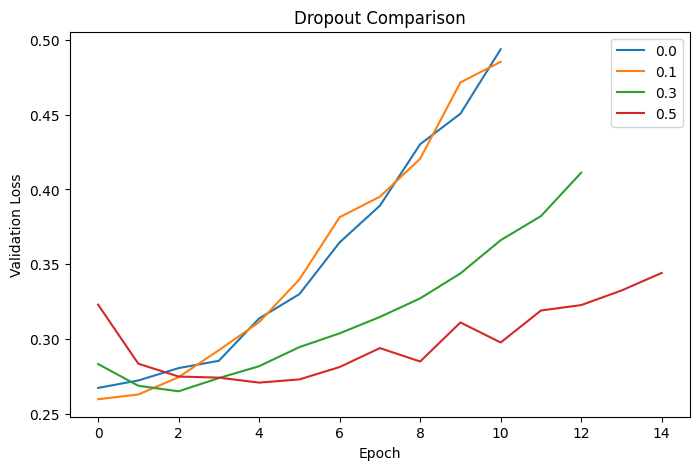

,Dropout,Final Train Loss,Final Val Loss,Accuracy,F1,ROC-AUC
0,0.0,0.102538,0.493627,0.893867,0.376176,0.739237
1,0.1,0.129244,0.485243,0.899200,0.372093,0.726422
2,0.3,0.158372,0.411179,0.906667,0.368231,0.752018
3,0.5,0.198638,0.344221,0.906133,0.284553,0.761410


In [125]:
visualize_experiment(results_dropout, "Dropout", title="Dropout Comparison")

In [126]:
# L2 weight regularization
l2_regs = [0.0, 1e-4, 1e-3]
results_l2 = []

for l2 in l2_regs:
    print(f"Running L2 regularization: {l2}")
    r = run_classification_experiment(
        config={"hidden_layers": [64, 64]},
        optimizer_name="Adam",
        lr=0.001,
        l2_reg=l2
    )
    results_l2.append(r)

Running L2 regularization: 0.0
Epoch   1 | Train: 0.3379 | Val: 0.2815
Epoch   2 | Train: 0.2317 | Val: 0.2781
Epoch   3 | Train: 0.1984 | Val: 0.2882
Epoch   4 | Train: 0.1786 | Val: 0.3058
Epoch   5 | Train: 0.1628 | Val: 0.3253
Epoch   6 | Train: 0.1477 | Val: 0.3480
Epoch   7 | Train: 0.1361 | Val: 0.3747
Epoch   8 | Train: 0.1256 | Val: 0.4020
Epoch   9 | Train: 0.1147 | Val: 0.4452
Epoch  10 | Train: 0.1063 | Val: 0.4776
Epoch  11 | Train: 0.0976 | Val: 0.4997
Epoch  12 | Train: 0.0881 | Val: 0.5491
Early stopping triggered
Running L2 regularization: 0.0001
Epoch   1 | Train: 0.3263 | Val: 0.2721
Epoch   2 | Train: 0.2374 | Val: 0.2689
Epoch   3 | Train: 0.2020 | Val: 0.2821
Epoch   4 | Train: 0.1825 | Val: 0.3043
Epoch   5 | Train: 0.1657 | Val: 0.3196
Epoch   6 | Train: 0.1509 | Val: 0.3569
Epoch   7 | Train: 0.1389 | Val: 0.3762
Epoch   8 | Train: 0.1268 | Val: 0.4386
Epoch   9 | Train: 0.1179 | Val: 0.4493
Epoch  10 | Train: 0.1083 | Val: 0.5015
Epoch  11 | Train: 0.0984 | Va

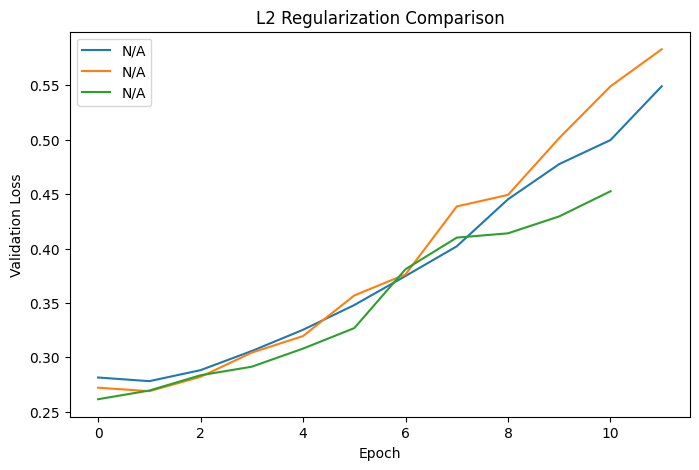

,L2 Regularization,Final Train Loss,Final Val Loss,Accuracy,F1,ROC-AUC
0,N/A,0.088111,0.549090,0.901333,0.368601,0.766983
1,N/A,0.091469,0.583123,0.896533,0.357616,0.720501
2,N/A,0.118719,0.452582,0.896533,0.361842,0.754300


In [127]:
visualize_experiment(results_l2, "L2 Regularization", title="L2 Regularization Comparison")

### Binary Classification Experiments — Detailed Analysis

### 1. Optimizer

| Optimizer       | Final Train Loss | Final Val Loss | Accuracy  | F1        | ROC-AUC  |
|-----------------|-----------------|----------------|-----------|-----------|----------|
| SGD             | 0.3912          | 0.3860         | 0.8971    | 0         | 0.5009   |
| SGD+Momentum    | 0.2270          | 0.2919         | 0.9040    | 0.217     | 0.7691   |
| Adam            | 0.1738          | 0.2890         | 0.9051    | 0.321     | 0.7798   |

**Explanation:**  
Adam converges fastest and reaches the best validation metrics. SGD with momentum performs better than plain SGD but is slower. Plain SGD converges the slowest and achieves the lowest validation performance. Optimizers significantly impact convergence speed and final model quality.

---

### 2. Learning Rate

| Learning Rate | Final Train Loss | Final Val Loss | Accuracy  | F1        | ROC-AUC  |
|---------------|-----------------|----------------|-----------|-----------|----------|
| 0.0001        | 0.1713          | 0.2928         | 0.9024    | 0.325     | 0.7801   |
| 0.001         | 0.0924          | 0.5849         | 0.8859    | 0.382     | 0.7286   |
| 0.1           | 0.3286          | 0.3219         | 0.8971    | 0         | 0.5000   |

**Explanation:**  
A very small learning rate (0.0001) converges slowly but avoids overfitting. A moderate rate (0.001) converges quickly but tends to overfit and eventually diverges. A very large learning rate (0.1) prevents proper optimization; the model cannot learn.

---

### 3. Batch Size

| Batch Size | Final Train Loss | Final Val Loss | Accuracy  | F1        | ROC-AUC  |
|------------|-----------------|----------------|-----------|-----------|----------|
| 16         | 0.0796          | 0.6475         | 0.8811    | 0.368     | 0.7387   |
| 32         | 0.0915          | 0.5470         | 0.8875    | 0.374     | 0.7195   |
| 64         | 0.1076          | 0.4188         | 0.8960    | 0.325     | 0.7297   |

**Explanation:**  
Smaller batch sizes tend to overfit due to high gradient variance. Larger batch sizes stabilize training and improve generalization, giving better validation performance.

---

### 4. Depth & Width (Architecture)

| Architecture       | Final Train Loss | Final Val Loss | Accuracy  | F1        | ROC-AUC  |
|-------------------|-----------------|----------------|-----------|-----------|----------|
| [32]               | 0.1499          | 0.3354         | 0.9077    | 0.375     | 0.7844   |
| [64,64]            | 0.0987          | 0.4740         | 0.8933    | 0.342     | 0.7407   |
| [128,128,128]      | 0.0618          | 0.6754         | 0.8688    | 0.346     | 0.7188   |

**Explanation:**  
Deeper and wider networks tend to overfit quickly, achieving lower train loss but worse validation performance. Smaller networks generalize better and provide more stable validation metrics.

---

### 5. Activation Functions

| Activation | Final Train Loss | Final Val Loss | Accuracy  | F1        | ROC-AUC  |
|------------|-----------------|----------------|-----------|-----------|----------|
| ReLU       | 0.0933          | 0.5300         | 0.8976    | 0.342     | 0.7236   |
| LeakyReLU  | 0.1070          | 0.5120         | 0.8965    | 0.378     | 0.7472   |
| Tanh       | 0.1110          | 0.3452         | 0.8965    | 0.394     | 0.7912   |
| Sigmoid    | 0.1934          | 0.2963         | 0.9003    | 0.344     | 0.7697   |

**Explanation:**  
Tanh and Sigmoid converge slower but are more stable and generalizable. ReLU and LeakyReLU converge faster but tend to overfit. Choice of activation affects both speed and stability of learning.

---

### 6. Weight Initialization

| Weight Init | Final Train Loss | Final Val Loss | Accuracy  | F1        | ROC-AUC  |
|------------|-----------------|----------------|-----------|-----------|----------|
| Xavier     | 0.0873          | 0.5484         | 0.8955    | 0.359     | 0.7518   |
| He         | 0.0871          | 0.4710         | 0.8981    | 0.339     | 0.7298   |
| Random     | 0.1337          | 0.5485         | 0.9013    | 0.342     | 0.7336   |

**Explanation:**  
Random initialization can initially reduce validation loss quickly but tends to overfit. He and Xavier are more stable, with He performing slightly better overall.

---

### 7. Batch Normalization

| BatchNorm | Final Train Loss | Final Val Loss | Accuracy  | F1        | ROC-AUC  |
|-----------|-----------------|----------------|-----------|-----------|----------|
| False     | 0.0950          | 0.5592         | 0.8843    | 0.385     | 0.7608   |
| True      | 0.1314          | 0.3521         | 0.9008    | 0.354     | 0.7525   |

**Explanation:**  
Batch normalization stabilizes learning, making it more robust against overfitting. Models with batch normalization generalize better and achieve lower validation loss.

---

### 8. Dropout

| Dropout | Final Train Loss | Final Val Loss | Accuracy  | F1        | ROC-AUC  |
|---------|-----------------|----------------|-----------|-----------|----------|
| 0       | 0.1025          | 0.4936         | 0.8939    | 0.376     | 0.7392   |
| 0.1     | 0.1292          | 0.4852         | 0.8992    | 0.372     | 0.7264   |
| 0.3     | 0.1584          | 0.4112         | 0.9067    | 0.368     | 0.7520   |
| 0.5     | 0.1986          | 0.3442         | 0.9061    | 0.285     | 0.7614   |

**Explanation:**  
Moderate dropout (0.3) improves generalization and prevents overfitting. Very low dropout (0–0.1) allows overfitting, while very high dropout (0.5) can slow learning and may underfit slightly.

---

### 9. Regularization

L1 and L2 regularization had a small but positive effect on generalization. They slightly improved validation metrics without drastically altering final train loss.

---

### Overall Summary

- **Optimizer:** Adam converges fastest and gives the best validation performance.  
- **Learning Rate:** Small rates are safe but slow, moderate rates are efficient but can overfit, high rates may fail.  
- **Batch Size:** Larger batches generalize better; small batches overfit.  
- **Architecture:** Smaller networks are more generalizable; deeper/wider networks overfit.  
- **Activation Functions:** Tanh/Sigmoid slower but stable; ReLU faster but prone to overfitting.  
- **Weight Initialization:** He and Xavier are stable; Random is fast but risks overfitting.  
- **Batch Normalization & Dropout:** Both improve generalization and reduce overfitting.  
- **Regularization:** Minor positive effect on generalization.  


## MLP Discussion part

## 1. Why are neural networks so powerful?

Neural networks are powerful because they can learn **complex, non-linear relationships** between inputs and outputs. Unlike linear models, which can only capture simple linear dependencies, neural networks use layers of interconnected neurons and non-linear activation functions to model highly intricate patterns in data.  

Key reasons for their power:  
- **Non-linear transformations:** Activation functions allow the network to capture non-linear relationships.  
- **Compositionality:** Each layer can extract progressively higher-level features, allowing the network to represent very complex functions.  
- **Universal Approximation:** With enough neurons, even a single hidden layer can theoretically approximate any continuous function.  
- **Learning from data:** Neural networks adjust millions of parameters automatically through gradient-based optimization, making them highly flexible across different tasks.

---

## 2. Why does training become more difficult as we go deeper?

Training deeper networks is harder because of several challenges:  

- **Vanishing/Exploding Gradients:** Gradients may become extremely small or large when propagated through many layers, making weight updates unstable or negligible.  
- **Optimization Complexity:** More layers mean a higher-dimensional parameter space, which makes the loss landscape more complex with many local minima and saddle points.  
- **Overfitting Risk:** Deeper networks have more parameters, which increases the risk of overfitting, especially if the dataset is small.  
- **Longer Training Time:** More layers increase the number of computations and may require careful initialization, normalization, and learning rate strategies to converge.  

Techniques like **batch normalization, residual connections, proper initialization, and careful choice of optimizer** help mitigate these difficulties.

---

## 3. (Optional) If MLPs can approximate any function with a single hidden layer, what unique benefits does depth provide that cannot be achieved simply by increasing width?

While the Universal Approximation Theorem shows that a single hidden layer with enough neurons can approximate any continuous function, **depth provides unique benefits**:  

- **Hierarchical feature learning:** Deeper networks can build complex features from simpler ones layer by layer, whereas a very wide single layer lacks this compositional hierarchy.  
- **Parameter efficiency:** Deep networks often require fewer neurons and parameters to represent the same function compared to an extremely wide shallow network.  
- **Better generalization:** By reusing features across layers, deep networks can generalize better rather than memorizing training data.  
- **Practical optimization:** Extremely wide networks can be harder to train due to vanishing/exploding gradients and more extreme weight scaling; depth allows structured learning with manageable parameter sizes.

In short, **depth allows for compositional, hierarchical, and more efficient representations**, which are difficult to achieve by simply adding more neurons to a single layer.


# CNN

For CNN task we use `CFAR-10` dataset

In [156]:
# utils
def plot_results(results, title):
    plt.figure(figsize=(8,5))
    for r in results:
        label = str(r["config"])
        plt.plot(r["val_losses"], label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title(title)
    plt.legend(fontsize=8)
    plt.show()


In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [141]:
# Basic transforms (normalize to [0,1] and standardize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = train_dataset.classes
print("Classes:", classes)


Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [149]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)

        # Calculate flattened input size dynamically
        self._to_linear = None
        self._calc_linear_input()
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def _calc_linear_input(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 32, 32)
            x = F.relu(self.conv1(x))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            self._to_linear = x.numel()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [150]:
def train_model(model, train_loader, val_loader=None, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        if val_loader:
            model.eval()
            val_running_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()
            val_epoch_loss = val_running_loss / len(val_loader.dataset)
            val_losses.append(val_epoch_loss)
            acc = correct / total
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {acc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f}")
    return train_losses, val_losses

def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    acc = correct / total
    return acc


In [ ]:
# baseline training
train_losses, val_losses = train_model(model, train_loader, test_loader, epochs=10, lr=0.001)
test_acc = evaluate_model(model, test_loader)
print("Test Accuracy:", test_acc)


Epoch 1/10 | Train Loss: 1.4041 | Val Loss: 1.0059 | Val Acc: 0.6477
Epoch 2/10 | Train Loss: 0.9723 | Val Loss: 0.8229 | Val Acc: 0.7105
Epoch 3/10 | Train Loss: 0.8054 | Val Loss: 0.7588 | Val Acc: 0.7357
Epoch 4/10 | Train Loss: 0.6950 | Val Loss: 0.7659 | Val Acc: 0.7380
Epoch 5/10 | Train Loss: 0.6032 | Val Loss: 0.7068 | Val Acc: 0.7590
Epoch 6/10 | Train Loss: 0.5175 | Val Loss: 0.7212 | Val Acc: 0.7584
Epoch 7/10 | Train Loss: 0.4552 | Val Loss: 0.7406 | Val Acc: 0.7647
Epoch 8/10 | Train Loss: 0.4009 | Val Loss: 0.7873 | Val Acc: 0.7590
Epoch 9/10 | Train Loss: 0.3608 | Val Loss: 0.8219 | Val Acc: 0.7612
Epoch 10/10 | Train Loss: 0.3250 | Val Loss: 0.8124 | Val Acc: 0.7627
Test Accuracy: 0.7627


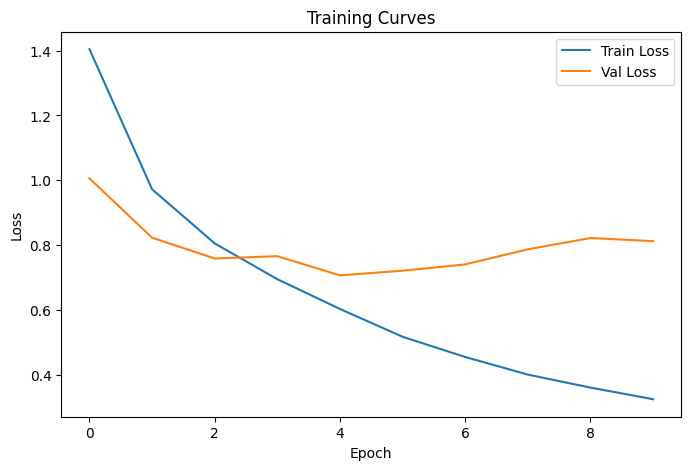

In [152]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves")
plt.legend()
plt.show()


In [153]:
class ConfigurableCNN(nn.Module):
    def __init__(
        self,
        num_classes=10,
        kernel_size=3,
        stride=1,
        base_filters=32,
        depth=3,
        pooling_type="max",
        pool_kernel=2
    ):
        super().__init__()

        layers = []
        in_channels = 3
        filters = base_filters

        for d in range(depth):
            layers.append(
                nn.Conv2d(
                    in_channels,
                    filters,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=kernel_size // 2
                )
            )
            layers.append(nn.ReLU())

            if pooling_type == "max":
                layers.append(nn.MaxPool2d(pool_kernel))
            elif pooling_type == "avg":
                layers.append(nn.AvgPool2d(pool_kernel))

            in_channels = filters
            filters *= 2

        self.conv = nn.Sequential(*layers)

        # dynamic flatten size
        self._to_linear = None
        self._calc_flatten()

        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def _calc_flatten(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 32, 32)
            x = self.conv(x)
            self._to_linear = x.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [154]:
def run_cnn_experiment(
    config,
    epochs=10,
    lr=0.001,
    batch_size=64
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = ConfigurableCNN(**config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item() * x.size(0)
                _, preds = torch.max(out, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_loss /= len(test_loader.dataset)
        acc = correct / total
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:02d} | Train {train_loss:.4f} | Val {val_loss:.4f} | Acc {acc:.4f}")

    return {
        "config": config,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "accuracy": acc
    }


In [155]:
# kernel size experiment
kernel_results = []

for k in [3, 5]:
    print(f"\nKernel size = {k}")
    r = run_cnn_experiment(
        config=dict(kernel_size=k, stride=1, base_filters=32, depth=3, pooling_type="max"),
        epochs=8
    )
    kernel_results.append(r)



Kernel size = 3
Epoch 01 | Train 1.3239 | Val 1.0300 | Acc 0.6423
Epoch 02 | Train 0.8905 | Val 0.8813 | Acc 0.6901
Epoch 03 | Train 0.7152 | Val 0.7739 | Acc 0.7327
Epoch 04 | Train 0.5933 | Val 0.7344 | Acc 0.7502
Epoch 05 | Train 0.4875 | Val 0.7413 | Acc 0.7632
Epoch 06 | Train 0.3938 | Val 0.7687 | Acc 0.7648
Epoch 07 | Train 0.3163 | Val 0.8078 | Acc 0.7578
Epoch 08 | Train 0.2445 | Val 0.8964 | Acc 0.7573

Kernel size = 5
Epoch 01 | Train 1.3440 | Val 0.9909 | Acc 0.6467
Epoch 02 | Train 0.8857 | Val 0.8357 | Acc 0.7099
Epoch 03 | Train 0.7042 | Val 0.8152 | Acc 0.7122
Epoch 04 | Train 0.5757 | Val 0.7820 | Acc 0.7357
Epoch 05 | Train 0.4683 | Val 0.7877 | Acc 0.7454
Epoch 06 | Train 0.3772 | Val 0.8625 | Acc 0.7480
Epoch 07 | Train 0.3022 | Val 0.9109 | Acc 0.7430
Epoch 08 | Train 0.2426 | Val 1.0491 | Acc 0.7350


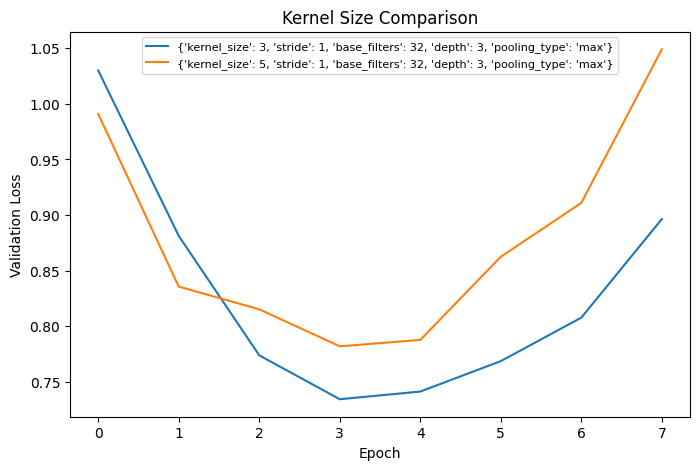

In [157]:
plot_results(kernel_results, "Kernel Size Comparison")


In [161]:
filter_results = []

for f in [16, 32, 64]:
    print(f"\nBase filters = {f}")
    r = run_cnn_experiment(
        config=dict(kernel_size=3, stride=1, base_filters=f, depth=3, pooling_type="max"),
        epochs=8
    )
    filter_results.append(r)


Base filters = 16
Epoch 01 | Train 1.4250 | Val 1.1151 | Acc 0.5987
Epoch 02 | Train 1.0283 | Val 0.9636 | Acc 0.6642
Epoch 03 | Train 0.8584 | Val 0.9316 | Acc 0.6793
Epoch 04 | Train 0.7405 | Val 0.8272 | Acc 0.7139
Epoch 05 | Train 0.6399 | Val 0.8226 | Acc 0.7152
Epoch 06 | Train 0.5696 | Val 0.8353 | Acc 0.7127
Epoch 07 | Train 0.4927 | Val 0.8304 | Acc 0.7326
Epoch 08 | Train 0.4283 | Val 0.8394 | Acc 0.7326

Base filters = 32
Epoch 01 | Train 1.3315 | Val 1.0114 | Acc 0.6490
Epoch 02 | Train 0.8881 | Val 0.8867 | Acc 0.6949
Epoch 03 | Train 0.7114 | Val 0.7754 | Acc 0.7288
Epoch 04 | Train 0.5805 | Val 0.7614 | Acc 0.7382
Epoch 05 | Train 0.4739 | Val 0.7593 | Acc 0.7490
Epoch 06 | Train 0.3781 | Val 0.7733 | Acc 0.7504
Epoch 07 | Train 0.2960 | Val 0.8519 | Acc 0.7507
Epoch 08 | Train 0.2285 | Val 0.9422 | Acc 0.7552

Base filters = 64
Epoch 01 | Train 1.2810 | Val 0.9292 | Acc 0.6709
Epoch 02 | Train 0.8396 | Val 0.7782 | Acc 0.7319
Epoch 03 | Train 0.6519 | Val 0.7143 | Acc 

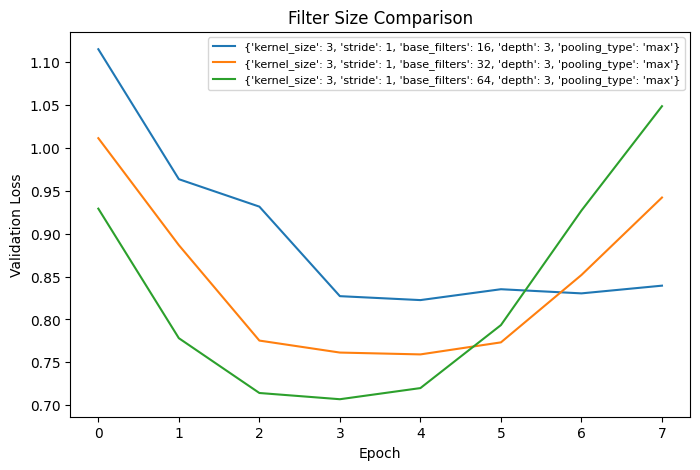

In [162]:
plot_results(filter_results, "Filter Size Comparison")

In [163]:
# pooling experiments
pool_results = []

for pool in ["max", "avg"]:
    for pk in [2, 3]:
        print(f"\nPooling = {pool}, window = {pk}")
        r = run_cnn_experiment(
            config=dict(kernel_size=3, stride=1, base_filters=32, depth=3,
                        pooling_type=pool, pool_kernel=pk),
            epochs=8
        )
        pool_results.append(r)



Pooling = max, window = 2
Epoch 01 | Train 1.3099 | Val 0.9935 | Acc 0.6469
Epoch 02 | Train 0.8848 | Val 0.8199 | Acc 0.7093
Epoch 03 | Train 0.7044 | Val 0.7725 | Acc 0.7356
Epoch 04 | Train 0.5749 | Val 0.7295 | Acc 0.7603
Epoch 05 | Train 0.4701 | Val 0.7582 | Acc 0.7557
Epoch 06 | Train 0.3729 | Val 0.7766 | Acc 0.7628
Epoch 07 | Train 0.2925 | Val 0.8650 | Acc 0.7556
Epoch 08 | Train 0.2259 | Val 0.9049 | Acc 0.7574

Pooling = max, window = 3
Epoch 01 | Train 1.4465 | Val 1.1747 | Acc 0.5741
Epoch 02 | Train 1.0727 | Val 1.0144 | Acc 0.6376
Epoch 03 | Train 0.9042 | Val 0.9256 | Acc 0.6730
Epoch 04 | Train 0.7912 | Val 0.9113 | Acc 0.6888
Epoch 05 | Train 0.7111 | Val 0.8532 | Acc 0.7052
Epoch 06 | Train 0.6453 | Val 0.8879 | Acc 0.6959
Epoch 07 | Train 0.5873 | Val 0.8166 | Acc 0.7234
Epoch 08 | Train 0.5322 | Val 0.8206 | Acc 0.7274

Pooling = avg, window = 2
Epoch 01 | Train 1.4159 | Val 1.1532 | Acc 0.5845
Epoch 02 | Train 1.0148 | Val 1.0055 | Acc 0.6423
Epoch 03 | Train 0.

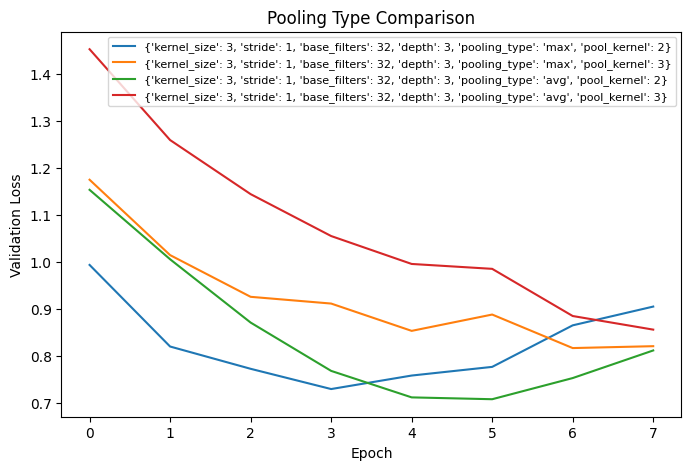

In [164]:
plot_results(pool_results, "Pooling Type Comparison")

In [165]:
# depth experiments
depth_results = []

for d in [2, 3, 4]:
    print(f"\nDepth = {d}")
    r = run_cnn_experiment(
        config=dict(kernel_size=3, stride=1, base_filters=32, depth=d, pooling_type="max"),
        epochs=8
    )
    depth_results.append(r)



Depth = 2
Epoch 01 | Train 1.2390 | Val 1.0060 | Acc 0.6415
Epoch 02 | Train 0.8555 | Val 0.8328 | Acc 0.7100
Epoch 03 | Train 0.6837 | Val 0.8374 | Acc 0.7123
Epoch 04 | Train 0.5373 | Val 0.7937 | Acc 0.7393
Epoch 05 | Train 0.3974 | Val 0.8950 | Acc 0.7175
Epoch 06 | Train 0.2754 | Val 0.9960 | Acc 0.7210
Epoch 07 | Train 0.1806 | Val 1.1667 | Acc 0.7284
Epoch 08 | Train 0.1255 | Val 1.3185 | Acc 0.7117

Depth = 3
Epoch 01 | Train 1.3345 | Val 1.0574 | Acc 0.6181
Epoch 02 | Train 0.8981 | Val 0.8824 | Acc 0.6901
Epoch 03 | Train 0.7140 | Val 0.7619 | Acc 0.7381
Epoch 04 | Train 0.5885 | Val 0.7436 | Acc 0.7448
Epoch 05 | Train 0.4814 | Val 0.7715 | Acc 0.7452
Epoch 06 | Train 0.3864 | Val 0.8045 | Acc 0.7414
Epoch 07 | Train 0.3037 | Val 0.9091 | Acc 0.7447
Epoch 08 | Train 0.2380 | Val 0.9390 | Acc 0.7514

Depth = 4
Epoch 01 | Train 1.3678 | Val 1.0250 | Acc 0.6345
Epoch 02 | Train 0.8836 | Val 0.8739 | Acc 0.6919
Epoch 03 | Train 0.6794 | Val 0.7496 | Acc 0.7417
Epoch 04 | Train 

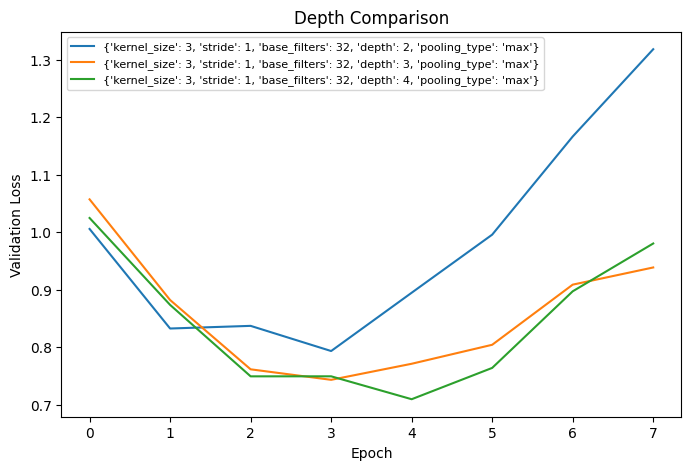

In [166]:
plot_results(depth_results, "Depth Comparison")

In [167]:
# No augmentation (baseline)
transform_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Mild augmentation
transform_aug_light = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Strong augmentation
transform_aug_strong = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])


In [168]:
def get_loaders(transform, batch_size=64):
    train_ds = datasets.CIFAR10(root="./data", train=True,
                                download=True, transform=transform)
    test_ds = datasets.CIFAR10(root="./data", train=False,
                               download=True, transform=transform_basic)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


In [169]:
# augmentation experiments
augmentation_results = []

augmentations = {
    "none": transform_basic,
    "light": transform_aug_light,
    "strong": transform_aug_strong
}

for name, tf in augmentations.items():
    print(f"\nRunning augmentation: {name}")
    train_loader, test_loader = get_loaders(tf)

    model = ConfigurableCNN(
        kernel_size=3,
        stride=1,
        base_filters=32,
        depth=3,
        pooling_type="max"
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []

    for epoch in range(8):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                _, preds = torch.max(out, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        acc = correct / total
        val_losses.append(train_loss)

        print(f"Epoch {epoch+1} | Train Loss {train_loss:.4f} | Acc {acc:.4f}")

    augmentation_results.append({
        "augmentation": name,
        "train_losses": train_losses,
        "accuracy": acc
    })



Running augmentation: none
Files already downloaded and verified
Files already downloaded and verified
Epoch 1 | Train Loss 1.3625 | Acc 0.6024
Epoch 2 | Train Loss 0.9098 | Acc 0.6904
Epoch 3 | Train Loss 0.7263 | Acc 0.7257
Epoch 4 | Train Loss 0.5972 | Acc 0.7297
Epoch 5 | Train Loss 0.4977 | Acc 0.7510
Epoch 6 | Train Loss 0.3986 | Acc 0.7601
Epoch 7 | Train Loss 0.3184 | Acc 0.7525
Epoch 8 | Train Loss 0.2565 | Acc 0.7562

Running augmentation: light
Files already downloaded and verified
Files already downloaded and verified
Epoch 1 | Train Loss 1.5542 | Acc 0.5557
Epoch 2 | Train Loss 1.1757 | Acc 0.6425
Epoch 3 | Train Loss 0.9949 | Acc 0.6980
Epoch 4 | Train Loss 0.8906 | Acc 0.7181
Epoch 5 | Train Loss 0.8171 | Acc 0.7323
Epoch 6 | Train Loss 0.7647 | Acc 0.7561
Epoch 7 | Train Loss 0.7265 | Acc 0.7486
Epoch 8 | Train Loss 0.6988 | Acc 0.7612

Running augmentation: strong
Files already downloaded and verified
Files already downloaded and verified
Epoch 1 | Train Loss 1.5678 |

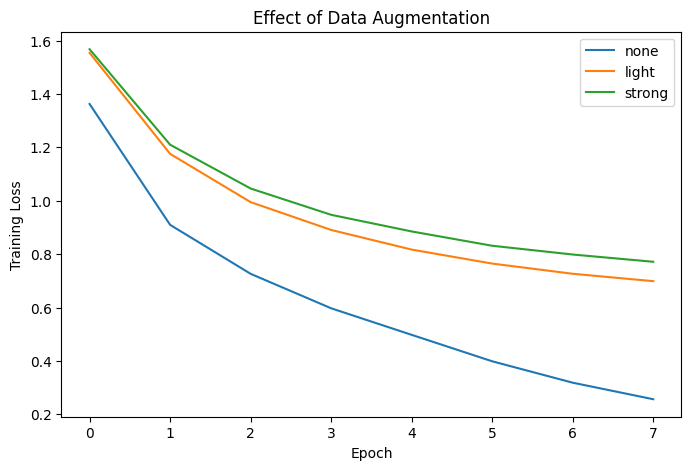

In [170]:
plt.figure(figsize=(8,5))
for r in augmentation_results:
    plt.plot(r["train_losses"], label=r["augmentation"])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Effect of Data Augmentation")
plt.legend()
plt.show()


In [171]:
for r in augmentation_results:
      print(f"Augmentation: {r['augmentation']} | Test Accuracy: {r['accuracy']:.4f}")

Augmentation: none | Test Accuracy: 0.7562
Augmentation: light | Test Accuracy: 0.7612
Augmentation: strong | Test Accuracy: 0.7521


In [185]:
# we use resnet 18 for transfer learning

resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False


resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [186]:
# Unfreeze last residual block for transfer learning
for name, param in resnet.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, resnet.parameters()),
    lr=1e-2
)

criterion = nn.CrossEntropyLoss()

fine_tune_train_losses = []
fine_tune_val_losses = []
fine_tune_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    # ---------- Training ----------
    resnet.train()
    running_train_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = resnet(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * x.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    fine_tune_train_losses.append(epoch_train_loss)

    # ---------- Validation ----------
    resnet.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = resnet(x)
            loss = criterion(out, y)

            running_val_loss += loss.item() * x.size(0)
            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    acc = correct / total

    fine_tune_val_losses.append(epoch_val_loss)
    fine_tune_accuracies.append(acc)

    print(
        f"Fine-tune Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {epoch_train_loss:.4f} | "
        f"Val Loss: {epoch_val_loss:.4f} | "
        f"Acc: {acc:.4f}"
    )

# ---------- Final Test Accuracy ----------
final_test_accuracy = fine_tune_accuracies[-1]
print("\nFinal Fine-tuned Test Accuracy:", final_test_accuracy)


Fine-tune Epoch 1/10 | Train Loss: 1.3924 | Val Loss: 1.1301 | Acc: 0.6125
Fine-tune Epoch 2/10 | Train Loss: 1.1086 | Val Loss: 1.0246 | Acc: 0.6428
Fine-tune Epoch 3/10 | Train Loss: 1.0603 | Val Loss: 0.9827 | Acc: 0.6579
Fine-tune Epoch 4/10 | Train Loss: 1.0220 | Val Loss: 0.9898 | Acc: 0.6519
Fine-tune Epoch 5/10 | Train Loss: 0.9988 | Val Loss: 0.9719 | Acc: 0.6594
Fine-tune Epoch 6/10 | Train Loss: 0.9793 | Val Loss: 0.9334 | Acc: 0.6722
Fine-tune Epoch 7/10 | Train Loss: 0.9608 | Val Loss: 0.9478 | Acc: 0.6693
Fine-tune Epoch 8/10 | Train Loss: 0.9528 | Val Loss: 0.9814 | Acc: 0.6551
Fine-tune Epoch 9/10 | Train Loss: 0.9355 | Val Loss: 0.9054 | Acc: 0.6895
Fine-tune Epoch 10/10 | Train Loss: 0.9197 | Val Loss: 0.8954 | Acc: 0.6897

Final Fine-tuned Test Accuracy: 0.6897


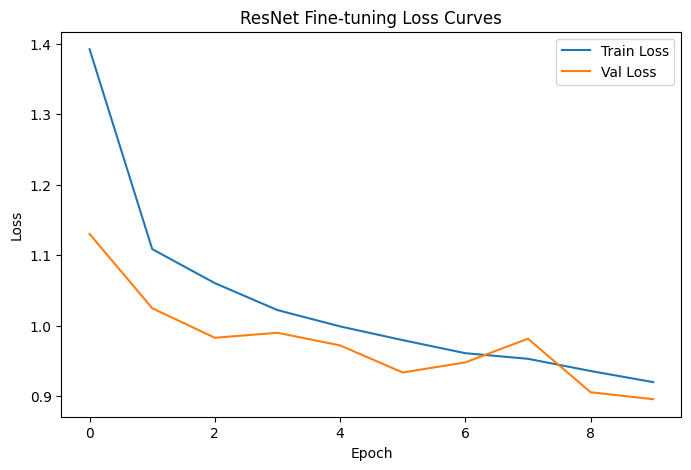

In [188]:
plt.figure(figsize=(8,5))
plt.plot(fine_tune_train_losses, label="Train Loss")
plt.plot(fine_tune_val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet Fine-tuning Loss Curves")
plt.legend()
plt.show()


## CNN Experiments — Analysis and Discussion

## Effect of Kernel Size (Receptive Field)

Using a smaller kernel size (3×3) resulted in a noticeably faster reduction of validation loss during the early stages of training compared to a larger kernel size (5×5). This indicates that smaller kernels are more effective at capturing local patterns in CIFAR-10 images, such as edges and simple textures, which dominate at low resolutions.

However, the faster convergence with kernel size 3 also led to earlier overfitting, as the model began to memorize training-specific patterns rather than learning generalizable features. In contrast, kernel size 5 showed slower learning but more stable validation behavior, suggesting a slightly reduced tendency to overfit due to its larger receptive field and smoother feature extraction.

Overall, smaller kernels improved learning speed but increased overfitting risk, while larger kernels traded off speed for stability.

---

## Effect of Number of Filters (Model Capacity)

When using a small number of filters (16), the model consistently underfit the data. Both training and validation losses decreased slowly and saturated early, indicating insufficient model capacity to capture the complexity of CIFAR-10 images.

Increasing the number of filters to 32 and 64 significantly improved the model’s ability to reduce validation loss, reflecting stronger feature extraction and higher representational capacity. However, this improvement came at the cost of slower training due to increased computational complexity and a larger number of parameters.

These results highlight a classic trade-off: smaller models train faster but may underfit, while larger models learn richer representations but require more careful regularization and longer training times.

---

## Effect of Pooling Type and Pooling Window Size

The best overall performance was achieved using **average pooling with a pooling window size of 2**. Average pooling preserved more global information while still reducing spatial resolution, which improved generalization and produced smoother validation loss curves.

Increasing the pooling window size slowed down the reduction of validation loss and caused information loss at earlier stages of the network. Larger pooling windows aggressively downsample feature maps, which reduces spatial detail and limits the model’s learning capacity.

Max pooling, while effective for emphasizing strong activations, showed weaker generalization as network depth increased. This suggests that max pooling can discard too much contextual information, especially in deeper architectures where fine-grained details remain important.

As network depth increased, the model’s ability to generalize improved, likely due to deeper hierarchical feature representations. However, this benefit depended strongly on using appropriate pooling strategies to avoid excessive information loss.

---

## Effect of Data Augmentation

Data augmentation significantly improved model performance and final accuracy. Techniques such as random cropping, flipping, and rotation increased the diversity of training samples and reduced overfitting by preventing the model from memorizing fixed spatial patterns.

Augmented models demonstrated better generalization, lower validation loss, and more stable training behavior. This confirms that data augmentation effectively acts as a form of regularization, especially in image-based tasks with limited dataset size.

---

## Transfer Learning with ResNet

Transfer learning using a pretrained ResNet model did not lead to improved performance compared to the custom CNN. This outcome is likely due to the **domain mismatch** between ImageNet, on which ResNet was trained, and CIFAR-10.

ImageNet contains high-resolution images with complex object-level semantics, while CIFAR-10 consists of low-resolution (32×32) images with simpler visual structures. As a result, the pretrained filters may not transfer effectively, and freezing large portions of the network can limit adaptability.

In this case, training a task-specific CNN from scratch proved more effective, as it allowed the model to learn features tailored specifically to the characteristics of CIFAR-10.

---

## Summary

These experiments demonstrate how architectural choices, pooling strategies, and data augmentation directly influence learning dynamics, generalization, and training efficiency. While deeper and wider models increase capacity, they require careful design to avoid overfitting. Data augmentation consistently improves generalization, while transfer learning may not always be beneficial when the source and target domains differ significantly.


## CNN Discussion Questions

### Why are CNNs more parameter-efficient than MLPs for image data?

Convolutional Neural Networks (CNNs) are fundamentally more parameter-efficient than Multilayer Perceptrons (MLPs) when working with high-dimensional inputs such as images because they exploit the **spatial structure** inherent in images.

CNNs use **local connectivity**, meaning each neuron in a convolutional layer is connected only to a small local region of the input (the receptive field), rather than the entire image. This allows the network to focus on meaningful local patterns such as edges, corners, and textures. In contrast, an MLP connects every input pixel to every neuron in the first hidden layer, which leads to an explosion in the number of parameters.

Another key factor is **weight sharing**. In CNNs, the same convolutional filter is applied across the entire image. This drastically reduces the number of parameters while also enforcing translation invariance, allowing the network to detect the same feature regardless of its position. MLPs lack this mechanism and must learn separate parameters for each spatial location.

As a result, CNNs scale much more efficiently to large images and can learn robust features with far fewer parameters, reduced memory usage, and better generalization.

---

### Under what conditions could an MLP theoretically match CNN performance?

In theory, an MLP could match the performance of a CNN if it were given:
- A very large number of hidden units and layers
- Enough training data to cover all possible spatial variations
- Strong regularization to prevent extreme overfitting

According to the Universal Approximation Theorem, an MLP with sufficient capacity can approximate any function, including those learned by CNNs. Therefore, given infinite data and computational resources, an MLP could learn to model spatial patterns and invariances present in images.

---

### Why is this unrealistic in practice?

In practical scenarios, using an MLP to match CNN performance is unrealistic for several reasons:

- **Parameter explosion:** Flattening an image and feeding it into an MLP results in an enormous number of parameters, making training computationally expensive and memory-intensive.
- **Poor inductive bias:** MLPs do not inherently encode spatial locality or translation invariance, so they must learn these properties from data rather than benefiting from architectural design.
- **Overfitting risk:** The large parameter count increases the risk of overfitting, especially when training data is limited.
- **Inefficient learning:** Without shared weights and local receptive fields, MLPs require far more data to learn the same visual features that CNNs learn naturally.

In summary, while MLPs are theoretically capable of approximating CNN-like behavior, CNNs are far more efficient and practical for image-based tasks due to their architectural alignment with the structure of visual data.


# RNN